In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

Timestep      Volt    Rotate  Pressure  Vibration  State  RUL
0            0  0.379151  0.556385  0.243080   0.229504      0  9.0
1            1  0.415507  0.698561  0.242410   0.273825      1  8.0
2            2  0.339342  0.637645  0.230266   0.191588      2  7.0
3            3  0.343817  0.627732  0.233905   0.264566      2  6.0
4            4  0.310362  0.607368  0.194296   0.240200      2  5.0
...        ...       ...       ...       ...        ...    ...  ...
7995      7995  0.333491  0.682035  0.220176   0.249060      0  NaN
7996      7996  0.344994  0.689298  0.225088   0.218040      1  NaN
7997      7997  0.390017  0.641338  0.211275   0.239294      1  NaN
7998      7998  0.324577  0.656867  0.205467   0.294698      1  NaN
7999      7999  0.388020  0.666028  0.281135   0.210243      1  NaN

[8000 rows x 7 columns]

In [7]:
#get starting points 
startingPoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        timePoint = row['Timestep'] + 1
        startingPoints.append(timePoint)

In [8]:
def getTimeFromStart(current, startList):
    currentEpisodeStartIndex = -1 #initialise negative value first
    for s in range(len(startList)):
        start = startList[s]
        if start - current > 0: 
            break 
        currentEpisodeStartIndex = s
    if currentEpisodeStartIndex >= 0:
        startPointTime = startList[currentEpisodeStartIndex]
        diff = current - startPointTime
        return int(diff)
    else: 
        return current

In [9]:
#get data on time elapsed from start of episode 
total_time_from_start = []
for timePoint in timeX:
    current_time_from_start = getTimeFromStart(timePoint, startingPoints)
    total_time_from_start.append(current_time_from_start)

In [10]:
all_df['Time_elapsed'] = total_time_from_start
all_df

Timestep      Volt    Rotate  Pressure  Vibration  State  RUL  \
0            0  0.379151  0.556385  0.243080   0.229504      0  9.0   
1            1  0.415507  0.698561  0.242410   0.273825      1  8.0   
2            2  0.339342  0.637645  0.230266   0.191588      2  7.0   
3            3  0.343817  0.627732  0.233905   0.264566      2  6.0   
4            4  0.310362  0.607368  0.194296   0.240200      2  5.0   
...        ...       ...       ...       ...        ...    ...  ...   
7995      7995  0.333491  0.682035  0.220176   0.249060      0  NaN   
7996      7996  0.344994  0.689298  0.225088   0.218040      1  NaN   
7997      7997  0.390017  0.641338  0.211275   0.239294      1  NaN   
7998      7998  0.324577  0.656867  0.205467   0.294698      1  NaN   
7999      7999  0.388020  0.666028  0.281135   0.210243      1  NaN   

      Time_elapsed  
0                0  
1                1  
2                2  
3                3  
4                4  
...            ...  
7995             3  
7996             4  
7997             5  
7998             6  
7999             7  

[8000 rows x 8 columns]

In [11]:
#add anomaly data

#load anomaly detection model
anomalyDetector = tf.keras.models.load_model('AE_tuneActivation_code_relu.h5')

anomalyData = []

for index, row in all_df.iterrows():
    sensorReadings = np.array([row['Volt'], row['Rotate'], row['Pressure'], row['Vibration']])
    sensorReadings = np.reshape(sensorReadings, (1,4))
    predictions = anomalyDetector.predict(sensorReadings)
    anomalyScore = (np.mean(np.power(sensorReadings - predictions, 2), axis=1))**0.5
    
    if anomalyScore < 0.0838:
        isAnomaly = 0
    else:
        isAnomaly = 1
        
    anomalyData.append(isAnomaly)
    
all_df['Anomalous'] = anomalyData

In [12]:
#drop na columns 
all_df = all_df.dropna()
all_df

Timestep      Volt    Rotate  Pressure  Vibration  State  RUL  \
0            0  0.379151  0.556385  0.243080   0.229504      0  9.0   
1            1  0.415507  0.698561  0.242410   0.273825      1  8.0   
2            2  0.339342  0.637645  0.230266   0.191588      2  7.0   
3            3  0.343817  0.627732  0.233905   0.264566      2  6.0   
4            4  0.310362  0.607368  0.194296   0.240200      2  5.0   
...        ...       ...       ...       ...        ...    ...  ...   
7987      7987  0.325059  0.616790  0.235959   0.192175      2  4.0   
7988      7988  0.388779  0.670864  0.243099   0.248306      2  3.0   
7989      7989  0.339885  0.607819  0.237883   0.232814      3  2.0   
7990      7990  0.525533  0.611479  0.414174   0.214225      3  1.0   
7991      7991  0.441301  0.296198  0.190694   0.236868      4  0.0   

      Time_elapsed  Anomalous  
0                0          0  
1                1          0  
2                2          0  
3                3          0  
4                4          0  
...            ...        ...  
7987             7          0  
7988             8          0  
7989             9          0  
7990            10          1  
7991            11          1  

[7992 rows x 9 columns]

In [13]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['Time_elapsed'], row['Anomalous'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [14]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [15]:
def splitDataIntoChunks3DWithAnomalyTimeInfo(data, chunk_size):
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:7])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][7])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [16]:
#set random seed 
tf.random.set_seed(42)

In [17]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

In [18]:
(trainX_4step_TAD, trainY_4step_TAD, trainTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(train_data, 4)
(valX_4step_TAD, valY_4step_TAD, valTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(val_data, 4)
(testX_4step_TAD, testY_4step_TAD, testTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(test_data, 4)

In [19]:
#check shape of X (training)
trainX_4step_TAD_arr = np.array(trainX_4step_TAD)
trainX_4step_TAD_arr.shape

(4022, 4, 6)

In [20]:
#check shape of y (training)
trainY_4step_TAD_arr = np.array(trainY_4step_TAD)
trainY_4step_TAD_arr = trainY_4step_TAD_arr.reshape(-1, 1)
trainY_4step_TAD_arr.shape

(4022, 1)

In [21]:
#check shape of X (validation)
valX_4step_TAD_arr = np.array(valX_4step_TAD)
valX_4step_TAD_arr.shape

(635, 4, 6)

In [22]:
#check shape of y (validation)
valY_4step_TAD_arr = np.array(valY_4step_TAD)
valY_4step_TAD_arr = valY_4step_TAD_arr.reshape(-1, 1)
valY_4step_TAD_arr.shape

(635, 1)

Investigate removing Dropout layer

In [23]:
#configure architecture 
model1 = models.Sequential()
model1.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 6), padding="same"))
model1.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model1.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model1.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(100, activation='relu'))
model1.add(layers.Dense(1, activation='relu'))

In [24]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [25]:
fileName1 = "CNN_noDropout.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName1,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [26]:
learning_model1 = model1.fit(trainX_4step_TAD_arr, trainY_4step_TAD_arr, epochs=500, batch_size=32, validation_data=(valX_4step_TAD_arr, valY_4step_TAD_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 1s 5ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 2/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 3/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 4/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 5/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 6/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.548

Epoch 50/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 51/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 52/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 53/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 54/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 55/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 

Epoch 99/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 100/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 101/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 102/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 103/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 104/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_er

126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 196/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 197/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 198/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 199/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 200/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480


126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 292/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 293/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 294/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 295/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 296/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480


126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 388/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 389/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 390/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 391/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 392/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480


126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 484/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 485/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 486/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 487/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480
Epoch 488/500
126/126 [==============================] - 0s 3ms/step - loss: 43.6151 - mean_squared_error: 43.6151 - val_loss: 29.5480 - val_mean_squared_error: 29.5480


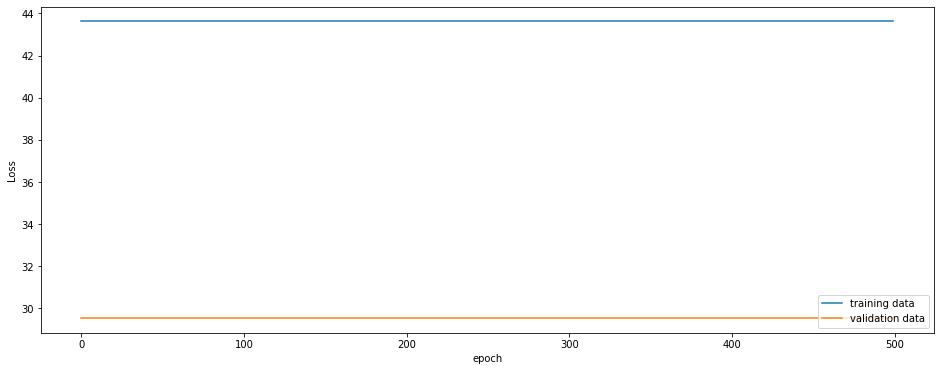

In [27]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model1.history['loss'])
plt.plot(learning_model1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [28]:
model1 = tf.keras.models.load_model('CNN_noDropout.h5')

In [29]:
#performance on training set
trainPredict1 = model1.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict1))
trainR2Score1 = r2_score(trainY_4step_TAD_arr, trainPredict1)
trainSscore1 = findSscore(trainY_4step_TAD_arr, trainPredict1)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore1, trainR2Score1, trainSscore1))

Train Score: 6.6042 RMSE -1.3361 R2 Score 6289.0873 S score


In [30]:
#performance on validation set
valPredict1 = model1.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore1 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict1))
valR2Score1 = r2_score(valY_4step_TAD_arr, valPredict1)
valSscore1 = findSscore(valY_4step_TAD_arr, valPredict1)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore1, valR2Score1, valSscore1))

Validation Score: 5.4358 RMSE -1.5794 R2 Score 913.2517 S score


In [31]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

In [32]:
allRUL = all_df['RUL']

In [33]:
(actualTrain1, predictedTrain1) = getRULValues(trainPredict1, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal1, predictedVal1) = getRULValues(valPredict1, allRUL, valTime_4step_TAD, 6010, 6976)

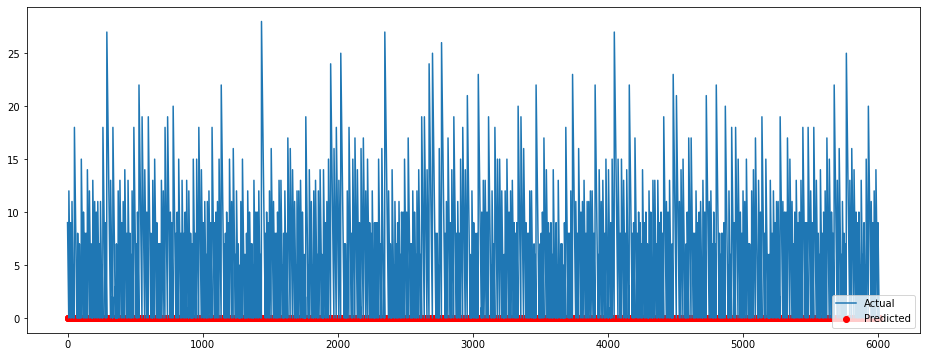

In [34]:
#training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain1)
plt.scatter(trainTime_4step_TAD, trainPredict1, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


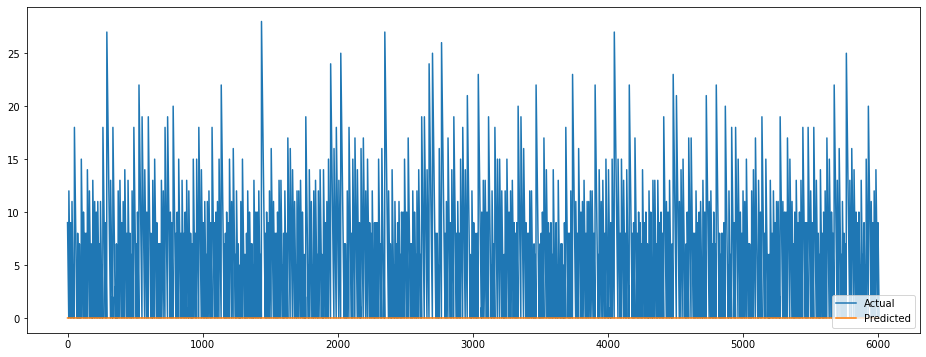

In [35]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain1)
plt.plot(trainTimeLabels, predictedTrain1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

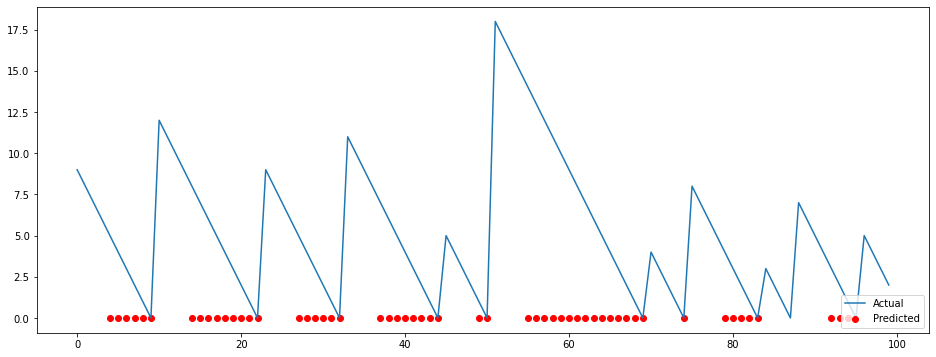

In [36]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain1[0:100])
plt.scatter(trainTime_4step_TAD[0:55], trainPredict1[0:55], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

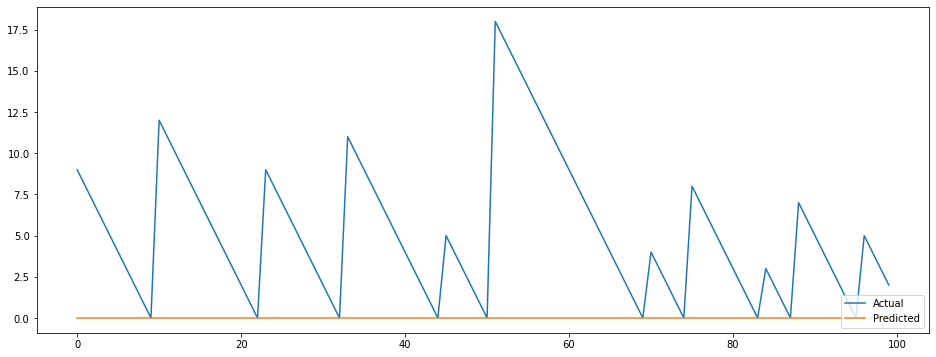

In [37]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain1[0:100])
plt.plot(trainTimeLabels[0:100], predictedTrain1[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

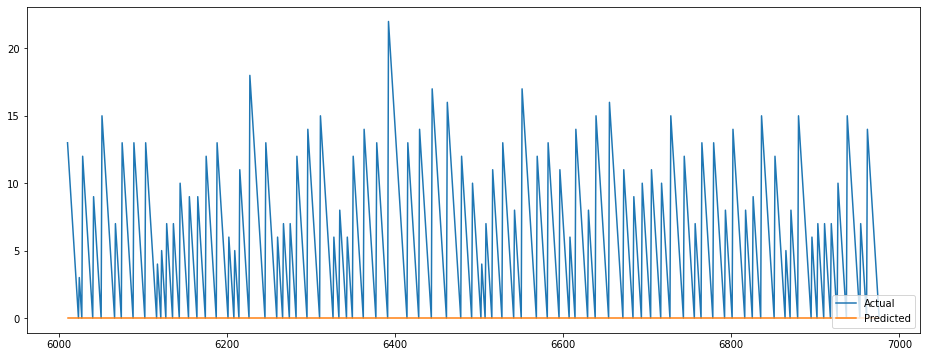

In [38]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal1)
plt.plot(valTimeLabels, predictedVal1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

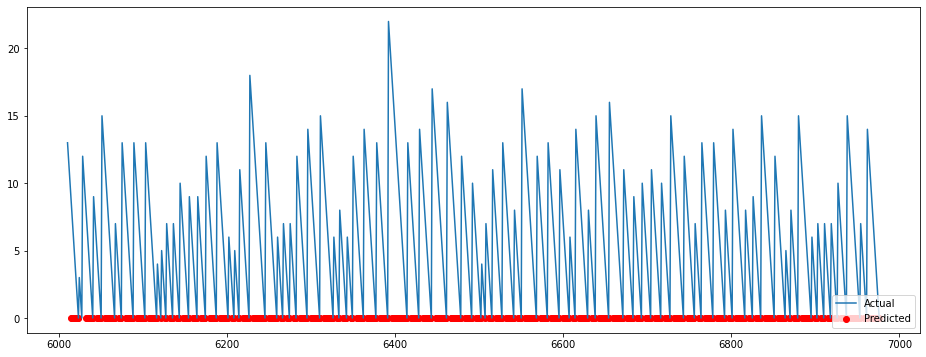

In [39]:
#validation set
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal1)
plt.scatter(valTime_4step_TAD, valPredict1, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

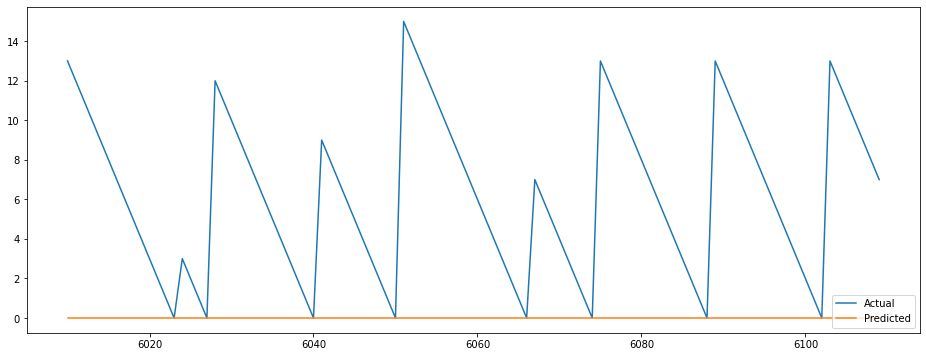

In [40]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal1[0:100])
plt.plot(valTimeLabels[0:100], predictedVal1[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

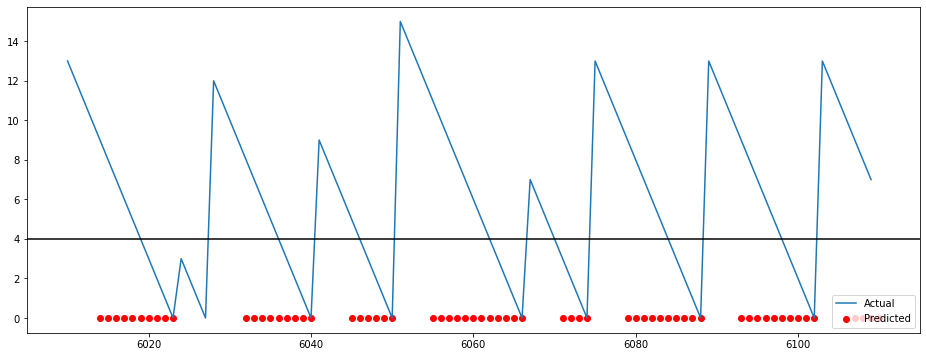

In [41]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal1[0:100])
plt.scatter(valTime_4step_TAD[0:65], valPredict1[0:65], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()

2 Max Pooling layers (Top)

In [42]:
#configure architecture 
model2 = models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 6), padding="same"))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model2.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model2.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))

In [43]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 4, 128)            2432      
                                                                 
 dropout (Dropout)           (None, 4, 128)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 4, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 32)             2080      
                                                                 
 dropout_1 (Dropout)         (None, 2, 32)             0         
                                                      

In [44]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [45]:
fileName2 = "CNN_2Dropout_front.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName2,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [46]:
learning_model2 = model2.fit(trainX_4step_TAD_arr, trainY_4step_TAD_arr, epochs=500, batch_size=32, validation_data=(valX_4step_TAD_arr, valY_4step_TAD_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 1s 5ms/step - loss: 22.6064 - mean_squared_error: 22.6064 - val_loss: 8.7028 - val_mean_squared_error: 8.7028
Epoch 2/500
126/126 [==============================] - 0s 4ms/step - loss: 19.0262 - mean_squared_error: 19.0262 - val_loss: 8.7230 - val_mean_squared_error: 8.7230
Epoch 3/500
126/126 [==============================] - 0s 4ms/step - loss: 18.2520 - mean_squared_error: 18.2520 - val_loss: 8.6839 - val_mean_squared_error: 8.6839
Epoch 4/500
126/126 [==============================] - 0s 4ms/step - loss: 18.0264 - mean_squared_error: 18.0264 - val_loss: 8.8488 - val_mean_squared_error: 8.8488
Epoch 5/500
126/126 [==============================] - 0s 4ms/step - loss: 17.7702 - mean_squared_error: 17.7702 - val_loss: 9.0107 - val_mean_squared_error: 9.0107
Epoch 6/500
126/126 [==============================] - 0s 3ms/step - loss: 17.6937 - mean_squared_error: 17.6937 - val_loss: 8.9141 - val_mean_squared_error: 8.9141
Epoch 7/50

126/126 [==============================] - 0s 3ms/step - loss: 16.2501 - mean_squared_error: 16.2501 - val_loss: 8.8614 - val_mean_squared_error: 8.8614
Epoch 100/500
126/126 [==============================] - 0s 3ms/step - loss: 16.1918 - mean_squared_error: 16.1918 - val_loss: 8.9159 - val_mean_squared_error: 8.9159
Epoch 101/500
126/126 [==============================] - 0s 3ms/step - loss: 16.1308 - mean_squared_error: 16.1308 - val_loss: 8.8091 - val_mean_squared_error: 8.8091
Epoch 102/500
126/126 [==============================] - 0s 3ms/step - loss: 16.2417 - mean_squared_error: 16.2417 - val_loss: 8.9288 - val_mean_squared_error: 8.9288
Epoch 103/500
126/126 [==============================] - 0s 3ms/step - loss: 16.2308 - mean_squared_error: 16.2308 - val_loss: 9.0452 - val_mean_squared_error: 9.0452
Epoch 104/500
126/126 [==============================] - 0s 3ms/step - loss: 16.1756 - mean_squared_error: 16.1756 - val_loss: 8.9843 - val_mean_squared_error: 8.9843
Epoch 105/50

126/126 [==============================] - 0s 3ms/step - loss: 16.0145 - mean_squared_error: 16.0145 - val_loss: 8.7320 - val_mean_squared_error: 8.7320
Epoch 198/500
126/126 [==============================] - 0s 4ms/step - loss: 15.9981 - mean_squared_error: 15.9981 - val_loss: 8.8014 - val_mean_squared_error: 8.8014
Epoch 199/500
126/126 [==============================] - 1s 4ms/step - loss: 16.0168 - mean_squared_error: 16.0168 - val_loss: 8.6696 - val_mean_squared_error: 8.6696
Epoch 200/500
126/126 [==============================] - 0s 3ms/step - loss: 15.8829 - mean_squared_error: 15.8829 - val_loss: 8.8873 - val_mean_squared_error: 8.8873
Epoch 201/500
126/126 [==============================] - 0s 3ms/step - loss: 15.9002 - mean_squared_error: 15.9002 - val_loss: 8.8281 - val_mean_squared_error: 8.8281
Epoch 202/500
126/126 [==============================] - 0s 3ms/step - loss: 15.9908 - mean_squared_error: 15.9908 - val_loss: 8.9071 - val_mean_squared_error: 8.9071
Epoch 203/50

126/126 [==============================] - 0s 3ms/step - loss: 15.8562 - mean_squared_error: 15.8562 - val_loss: 8.6653 - val_mean_squared_error: 8.6653
Epoch 296/500
126/126 [==============================] - 0s 3ms/step - loss: 15.8586 - mean_squared_error: 15.8586 - val_loss: 8.6543 - val_mean_squared_error: 8.6543
Epoch 297/500
126/126 [==============================] - 0s 4ms/step - loss: 15.8087 - mean_squared_error: 15.8087 - val_loss: 8.9530 - val_mean_squared_error: 8.9530
Epoch 298/500
126/126 [==============================] - 1s 4ms/step - loss: 15.6736 - mean_squared_error: 15.6736 - val_loss: 8.7192 - val_mean_squared_error: 8.7192
Epoch 299/500
126/126 [==============================] - 0s 3ms/step - loss: 15.7497 - mean_squared_error: 15.7497 - val_loss: 8.7293 - val_mean_squared_error: 8.7293
Epoch 300/500
126/126 [==============================] - 0s 3ms/step - loss: 15.7899 - mean_squared_error: 15.7899 - val_loss: 9.0576 - val_mean_squared_error: 9.0576
Epoch 301/50

126/126 [==============================] - 0s 4ms/step - loss: 15.6274 - mean_squared_error: 15.6274 - val_loss: 8.7159 - val_mean_squared_error: 8.7159
Epoch 394/500
126/126 [==============================] - 0s 3ms/step - loss: 15.6107 - mean_squared_error: 15.6107 - val_loss: 8.6984 - val_mean_squared_error: 8.6984
Epoch 395/500
126/126 [==============================] - 0s 3ms/step - loss: 15.6084 - mean_squared_error: 15.6084 - val_loss: 8.9392 - val_mean_squared_error: 8.9392
Epoch 396/500
126/126 [==============================] - 0s 3ms/step - loss: 15.6949 - mean_squared_error: 15.6949 - val_loss: 8.6396 - val_mean_squared_error: 8.6396
Epoch 397/500
126/126 [==============================] - 0s 4ms/step - loss: 15.7606 - mean_squared_error: 15.7606 - val_loss: 8.6508 - val_mean_squared_error: 8.6508
Epoch 398/500
126/126 [==============================] - 0s 3ms/step - loss: 15.7024 - mean_squared_error: 15.7024 - val_loss: 8.8879 - val_mean_squared_error: 8.8879
Epoch 399/50

126/126 [==============================] - 1s 5ms/step - loss: 15.4067 - mean_squared_error: 15.4067 - val_loss: 8.5868 - val_mean_squared_error: 8.5868
Epoch 492/500
126/126 [==============================] - 1s 5ms/step - loss: 15.5668 - mean_squared_error: 15.5668 - val_loss: 8.6618 - val_mean_squared_error: 8.6618
Epoch 493/500
126/126 [==============================] - 1s 5ms/step - loss: 15.4765 - mean_squared_error: 15.4765 - val_loss: 8.6194 - val_mean_squared_error: 8.6194
Epoch 494/500
126/126 [==============================] - 1s 5ms/step - loss: 15.4039 - mean_squared_error: 15.4039 - val_loss: 8.8452 - val_mean_squared_error: 8.8452
Epoch 495/500
126/126 [==============================] - 1s 5ms/step - loss: 15.4200 - mean_squared_error: 15.4200 - val_loss: 8.6177 - val_mean_squared_error: 8.6177
Epoch 496/500
126/126 [==============================] - 1s 4ms/step - loss: 15.4711 - mean_squared_error: 15.4711 - val_loss: 8.5717 - val_mean_squared_error: 8.5717
Epoch 497/50

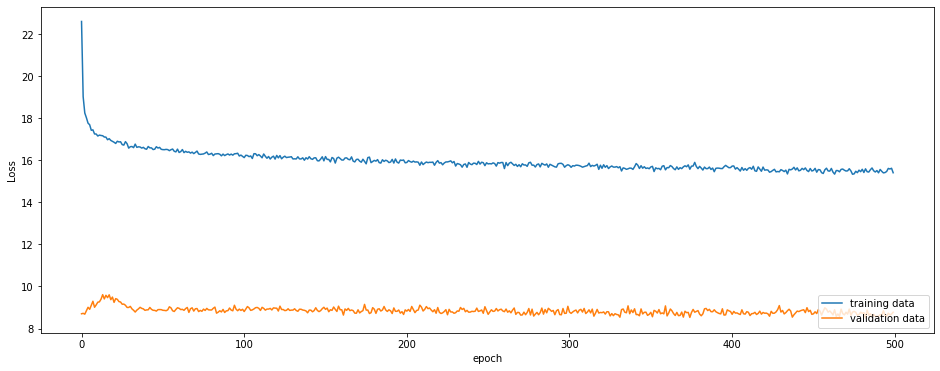

In [47]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model2.history['loss'])
plt.plot(learning_model2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [48]:
model2 = tf.keras.models.load_model('CNN_2Dropout_front.h5')

In [49]:
#performance on training set
trainPredict2 = model2.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict2))
trainR2Score2 = r2_score(trainY_4step_TAD_arr, trainPredict2)
trainSscore2 = findSscore(trainY_4step_TAD_arr, trainPredict2)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore2, trainR2Score2, trainSscore2))

Train Score: 3.9016 RMSE 0.1847 R2 Score 5345.7171 S score


In [50]:
#performance on validation set
valPredict2 = model2.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore2 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict2))
valR2Score2 = r2_score(valY_4step_TAD_arr, valPredict2)
valSscore2 = findSscore(valY_4step_TAD_arr, valPredict2)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore2, valR2Score2, valSscore2))

Validation Score: 2.9159 RMSE 0.2578 R2 Score 800.3570 S score


In [51]:
(actualTrain2, predictedTrain2) = getRULValues(trainPredict2, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal2, predictedVal2) = getRULValues(valPredict2, allRUL, valTime_4step_TAD, 6010, 6976)

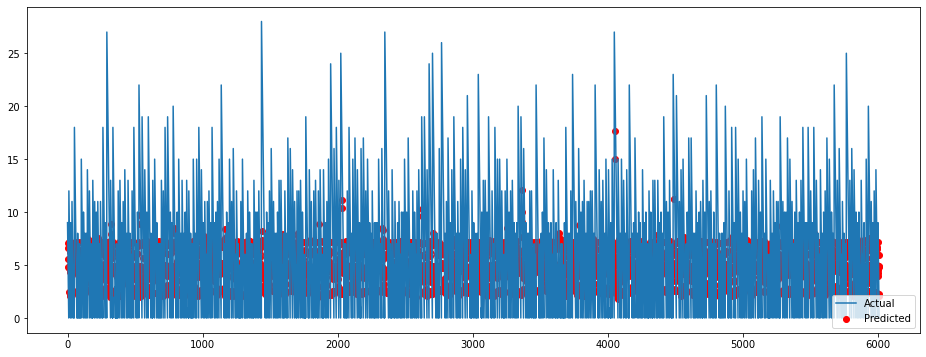

In [52]:
#training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain2)
plt.scatter(trainTime_4step_TAD, trainPredict2, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


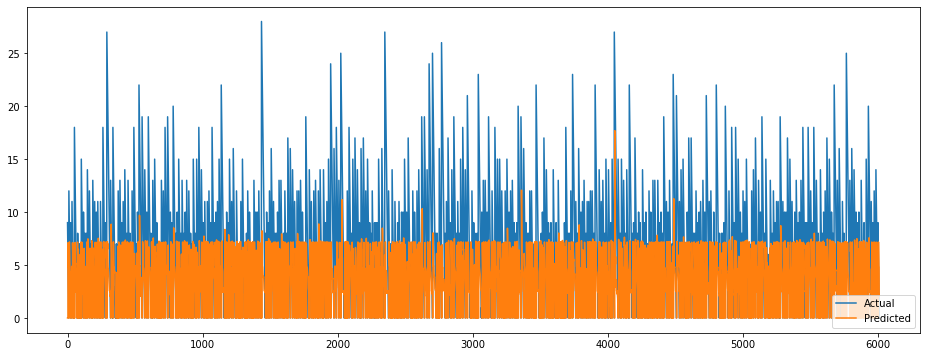

In [53]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain2)
plt.plot(trainTimeLabels, predictedTrain2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

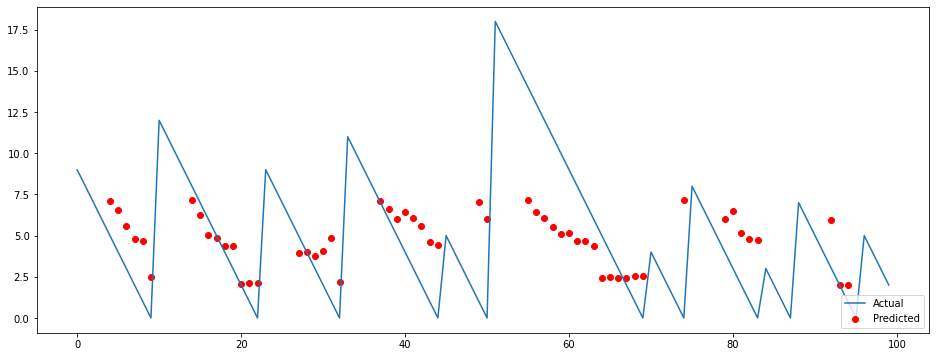

In [54]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain2[0:100])
plt.scatter(trainTime_4step_TAD[0:55], trainPredict2[0:55], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

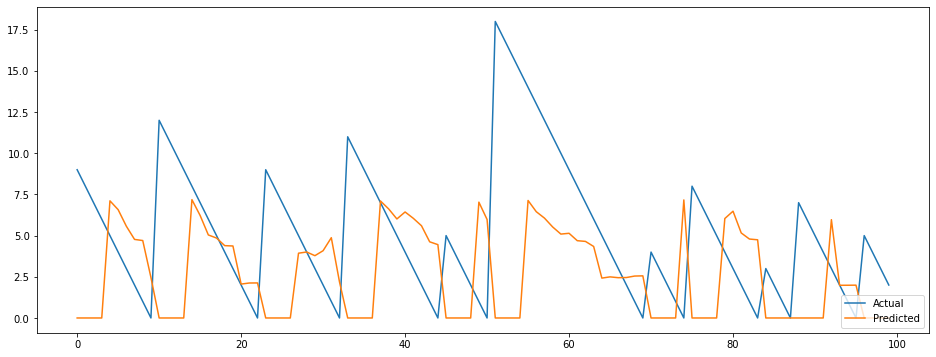

In [55]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain2[0:100])
plt.plot(trainTimeLabels[0:100], predictedTrain2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

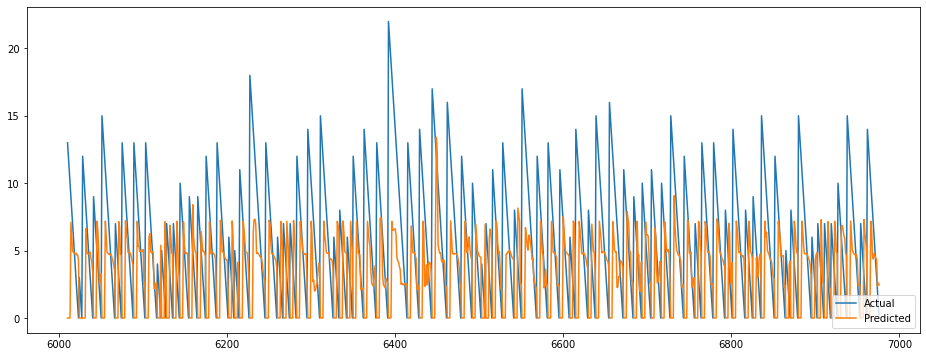

In [56]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal2)
plt.plot(valTimeLabels, predictedVal2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

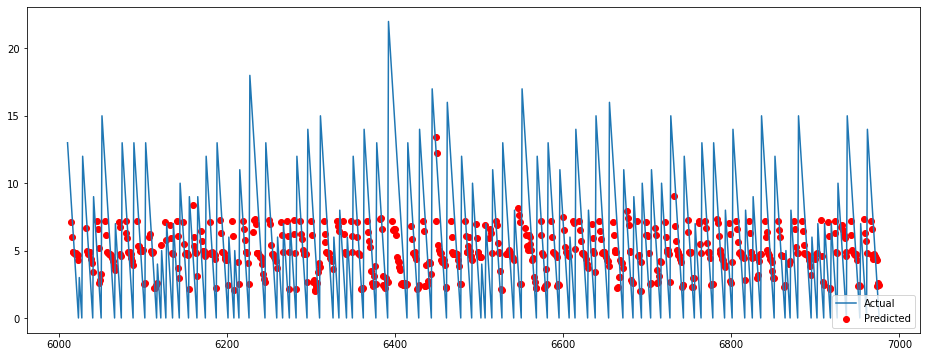

In [57]:
#validation set
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal2)
plt.scatter(valTime_4step_TAD, valPredict2, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

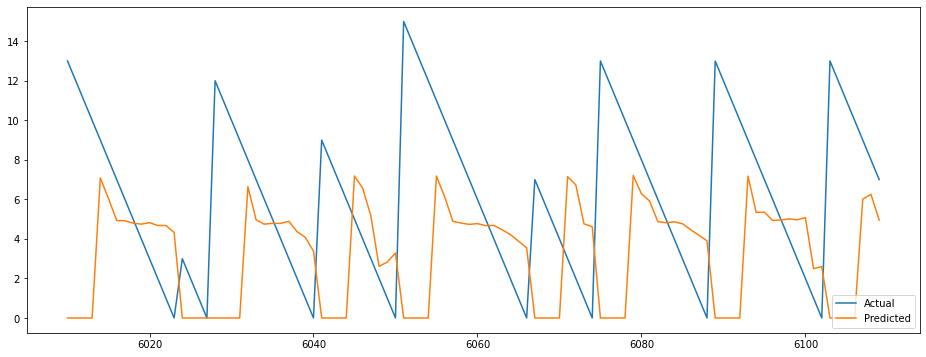

In [58]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal2[0:100])
plt.plot(valTimeLabels[0:100], predictedVal2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

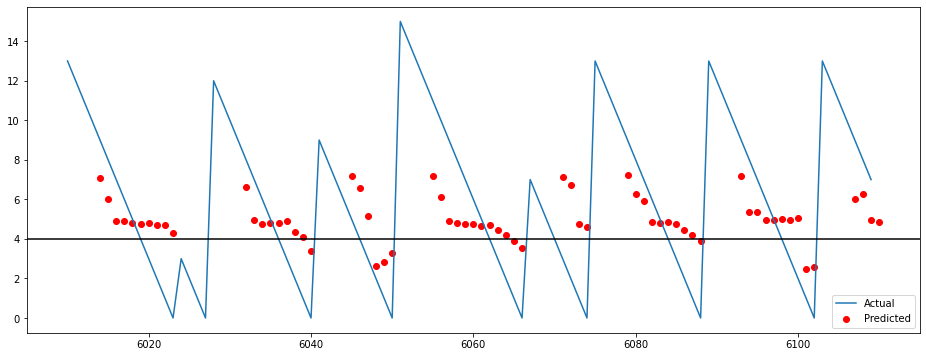

In [59]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal2[0:100])
plt.scatter(valTime_4step_TAD[0:65], valPredict2[0:65], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()

2 Dropout layers (middle)

In [128]:
#configure architecture 
model3 = models.Sequential()
model3.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 6), padding="same"))
model3.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model3.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Flatten())
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(1, activation='relu'))

In [129]:
model3.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [130]:
fileName3 = "CNN_2Dropout_middle.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName3,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [131]:
learning_model3 = model3.fit(trainX_4step_TAD_arr, trainY_4step_TAD_arr, epochs=700, batch_size=32, validation_data=(valX_4step_TAD_arr, valY_4step_TAD_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/700
126/126 [==============================] - 2s 7ms/step - loss: 21.2956 - mean_squared_error: 21.2956 - val_loss: 8.8580 - val_mean_squared_error: 8.8580
Epoch 2/700
126/126 [==============================] - 1s 5ms/step - loss: 18.6394 - mean_squared_error: 18.6394 - val_loss: 9.0460 - val_mean_squared_error: 9.0460
Epoch 3/700
126/126 [==============================] - 1s 5ms/step - loss: 17.7390 - mean_squared_error: 17.7390 - val_loss: 9.1426 - val_mean_squared_error: 9.1426
Epoch 4/700
126/126 [==============================] - 1s 6ms/step - loss: 17.5724 - mean_squared_error: 17.5724 - val_loss: 9.2630 - val_mean_squared_error: 9.2630
Epoch 5/700
126/126 [==============================] - 1s 5ms/step - loss: 17.3180 - mean_squared_error: 17.3180 - val_loss: 9.2792 - val_mean_squared_error: 9.2792
Epoch 6/700
126/126 [==============================] - 1s 5ms/step - loss: 17.2090 - mean_squared_error: 17.2090 - val_loss: 9.4076 - val_mean_squared_error: 9.4076
Epoch 7/70

126/126 [==============================] - 1s 6ms/step - loss: 16.0296 - mean_squared_error: 16.0296 - val_loss: 9.0910 - val_mean_squared_error: 9.0910
Epoch 100/700
126/126 [==============================] - 1s 5ms/step - loss: 16.0438 - mean_squared_error: 16.0438 - val_loss: 9.1450 - val_mean_squared_error: 9.1450
Epoch 101/700
126/126 [==============================] - 1s 6ms/step - loss: 15.9437 - mean_squared_error: 15.9437 - val_loss: 9.0338 - val_mean_squared_error: 9.0338
Epoch 102/700
126/126 [==============================] - 1s 5ms/step - loss: 16.0467 - mean_squared_error: 16.0467 - val_loss: 9.0054 - val_mean_squared_error: 9.0054
Epoch 103/700
126/126 [==============================] - 1s 5ms/step - loss: 15.9515 - mean_squared_error: 15.9515 - val_loss: 9.1314 - val_mean_squared_error: 9.1314
Epoch 104/700
126/126 [==============================] - 1s 5ms/step - loss: 16.1402 - mean_squared_error: 16.1402 - val_loss: 9.0375 - val_mean_squared_error: 9.0375
Epoch 105/70

126/126 [==============================] - 1s 5ms/step - loss: 15.5788 - mean_squared_error: 15.5788 - val_loss: 8.9268 - val_mean_squared_error: 8.9268
Epoch 198/700
126/126 [==============================] - 1s 5ms/step - loss: 15.7874 - mean_squared_error: 15.7874 - val_loss: 8.9387 - val_mean_squared_error: 8.9387
Epoch 199/700
126/126 [==============================] - 1s 5ms/step - loss: 15.6959 - mean_squared_error: 15.6959 - val_loss: 8.7624 - val_mean_squared_error: 8.7624
Epoch 200/700
126/126 [==============================] - 1s 5ms/step - loss: 15.5839 - mean_squared_error: 15.5839 - val_loss: 8.8169 - val_mean_squared_error: 8.8169
Epoch 201/700
126/126 [==============================] - 1s 6ms/step - loss: 15.7555 - mean_squared_error: 15.7555 - val_loss: 8.7883 - val_mean_squared_error: 8.7883
Epoch 202/700
126/126 [==============================] - 1s 6ms/step - loss: 15.6510 - mean_squared_error: 15.6510 - val_loss: 8.7978 - val_mean_squared_error: 8.7978
Epoch 203/70

126/126 [==============================] - 0s 3ms/step - loss: 15.3538 - mean_squared_error: 15.3538 - val_loss: 8.7421 - val_mean_squared_error: 8.7421
Epoch 296/700
126/126 [==============================] - 0s 3ms/step - loss: 15.3362 - mean_squared_error: 15.3362 - val_loss: 8.6429 - val_mean_squared_error: 8.6429
Epoch 297/700
126/126 [==============================] - 0s 3ms/step - loss: 15.3391 - mean_squared_error: 15.3391 - val_loss: 8.7859 - val_mean_squared_error: 8.7859
Epoch 298/700
126/126 [==============================] - 0s 3ms/step - loss: 15.3263 - mean_squared_error: 15.3263 - val_loss: 8.9550 - val_mean_squared_error: 8.9550
Epoch 299/700
126/126 [==============================] - 0s 3ms/step - loss: 15.3266 - mean_squared_error: 15.3266 - val_loss: 8.6765 - val_mean_squared_error: 8.6765
Epoch 300/700
126/126 [==============================] - 0s 3ms/step - loss: 15.2569 - mean_squared_error: 15.2569 - val_loss: 8.5278 - val_mean_squared_error: 8.5278
Epoch 301/70

126/126 [==============================] - 0s 3ms/step - loss: 15.0683 - mean_squared_error: 15.0683 - val_loss: 8.6325 - val_mean_squared_error: 8.6325
Epoch 394/700
126/126 [==============================] - 0s 3ms/step - loss: 15.1153 - mean_squared_error: 15.1153 - val_loss: 8.4955 - val_mean_squared_error: 8.4955
Epoch 395/700
126/126 [==============================] - 0s 3ms/step - loss: 15.0628 - mean_squared_error: 15.0628 - val_loss: 8.5451 - val_mean_squared_error: 8.5451
Epoch 396/700
126/126 [==============================] - 0s 3ms/step - loss: 14.9369 - mean_squared_error: 14.9369 - val_loss: 8.4075 - val_mean_squared_error: 8.4075
Epoch 397/700
126/126 [==============================] - 0s 4ms/step - loss: 15.1315 - mean_squared_error: 15.1315 - val_loss: 8.5286 - val_mean_squared_error: 8.5286
Epoch 398/700
126/126 [==============================] - 0s 3ms/step - loss: 14.9547 - mean_squared_error: 14.9547 - val_loss: 8.5170 - val_mean_squared_error: 8.5170
Epoch 399/70

126/126 [==============================] - 0s 3ms/step - loss: 14.8461 - mean_squared_error: 14.8461 - val_loss: 8.5345 - val_mean_squared_error: 8.5345
Epoch 492/700
126/126 [==============================] - 0s 3ms/step - loss: 14.9130 - mean_squared_error: 14.9130 - val_loss: 8.6334 - val_mean_squared_error: 8.6334
Epoch 493/700
126/126 [==============================] - 0s 3ms/step - loss: 14.7928 - mean_squared_error: 14.7928 - val_loss: 8.6224 - val_mean_squared_error: 8.6224
Epoch 494/700
126/126 [==============================] - 0s 3ms/step - loss: 14.6736 - mean_squared_error: 14.6736 - val_loss: 8.5958 - val_mean_squared_error: 8.5958
Epoch 495/700
126/126 [==============================] - 0s 3ms/step - loss: 14.8531 - mean_squared_error: 14.8531 - val_loss: 8.6173 - val_mean_squared_error: 8.6173
Epoch 496/700
126/126 [==============================] - 0s 3ms/step - loss: 14.8602 - mean_squared_error: 14.8602 - val_loss: 8.7466 - val_mean_squared_error: 8.7466
Epoch 497/70

126/126 [==============================] - 0s 4ms/step - loss: 14.5837 - mean_squared_error: 14.5837 - val_loss: 8.6065 - val_mean_squared_error: 8.6065
Epoch 590/700
126/126 [==============================] - 0s 3ms/step - loss: 14.4775 - mean_squared_error: 14.4775 - val_loss: 8.8070 - val_mean_squared_error: 8.8070
Epoch 591/700
126/126 [==============================] - 0s 3ms/step - loss: 14.5892 - mean_squared_error: 14.5892 - val_loss: 8.7824 - val_mean_squared_error: 8.7824
Epoch 592/700
126/126 [==============================] - 0s 3ms/step - loss: 14.5975 - mean_squared_error: 14.5975 - val_loss: 8.6885 - val_mean_squared_error: 8.6885
Epoch 593/700
126/126 [==============================] - 0s 3ms/step - loss: 14.5709 - mean_squared_error: 14.5709 - val_loss: 8.8427 - val_mean_squared_error: 8.8427
Epoch 594/700
126/126 [==============================] - 0s 3ms/step - loss: 14.6249 - mean_squared_error: 14.6249 - val_loss: 8.7372 - val_mean_squared_error: 8.7372
Epoch 595/70

126/126 [==============================] - 0s 3ms/step - loss: 14.5171 - mean_squared_error: 14.5171 - val_loss: 8.5901 - val_mean_squared_error: 8.5901
Epoch 688/700
126/126 [==============================] - 0s 4ms/step - loss: 14.3797 - mean_squared_error: 14.3797 - val_loss: 8.7264 - val_mean_squared_error: 8.7264
Epoch 689/700
126/126 [==============================] - 0s 4ms/step - loss: 14.4883 - mean_squared_error: 14.4883 - val_loss: 8.6608 - val_mean_squared_error: 8.6608
Epoch 690/700
126/126 [==============================] - 0s 3ms/step - loss: 14.4325 - mean_squared_error: 14.4325 - val_loss: 8.7758 - val_mean_squared_error: 8.7758
Epoch 691/700
126/126 [==============================] - 0s 3ms/step - loss: 14.4481 - mean_squared_error: 14.4481 - val_loss: 8.6852 - val_mean_squared_error: 8.6852
Epoch 692/700
126/126 [==============================] - 0s 3ms/step - loss: 14.5044 - mean_squared_error: 14.5044 - val_loss: 8.5723 - val_mean_squared_error: 8.5723
Epoch 693/70

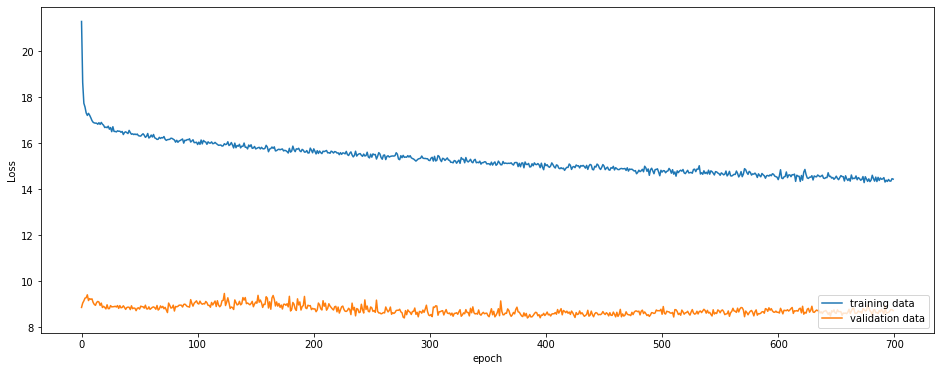

In [132]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model3.history['loss'])
plt.plot(learning_model3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [133]:
model3 = tf.keras.models.load_model('CNN_2Dropout_middle.h5')

In [134]:
#performance on training set
trainPredict3 = model3.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore3 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict3))
trainR2Score3 = r2_score(trainY_4step_TAD_arr, trainPredict3)
trainSscore3 = findSscore(trainY_4step_TAD_arr, trainPredict3)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore3, trainR2Score3, trainSscore3))

Train Score: 3.8537 RMSE 0.2045 R2 Score 5301.4503 S score


In [135]:
#performance on validation set
valPredict3 = model3.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore3 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict3))
valR2Score3 = r2_score(valY_4step_TAD_arr, valPredict3)
valSscore3 = findSscore(valY_4step_TAD_arr, valPredict3)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore3, valR2Score3, valSscore3))

Validation Score: 2.8982 RMSE 0.2668 R2 Score 794.7274 S score


In [136]:
(actualTrain3, predictedTrain3) = getRULValues(trainPredict3, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal3, predictedVal3) = getRULValues(valPredict3, allRUL, valTime_4step_TAD, 6010, 6976)

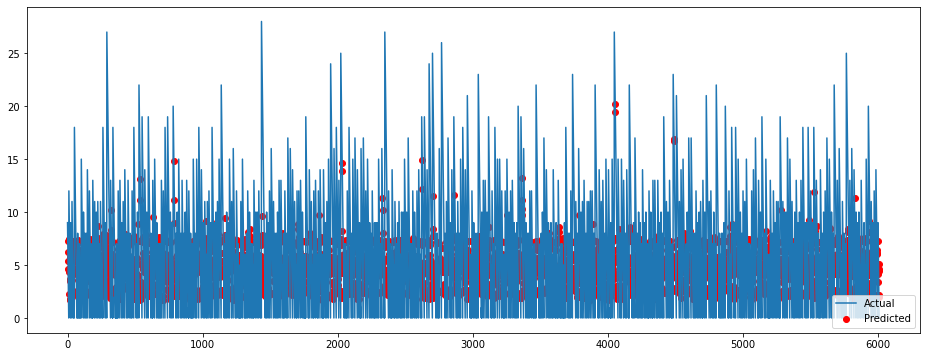

In [137]:
#training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain3)
plt.scatter(trainTime_4step_TAD, trainPredict3, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


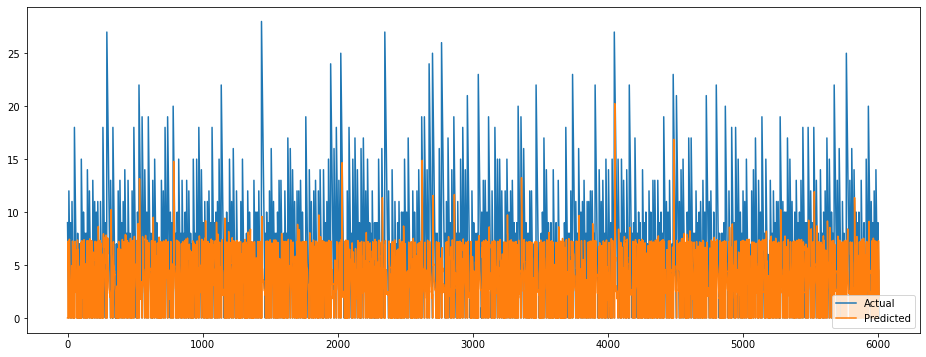

In [138]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain3)
plt.plot(trainTimeLabels, predictedTrain3)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

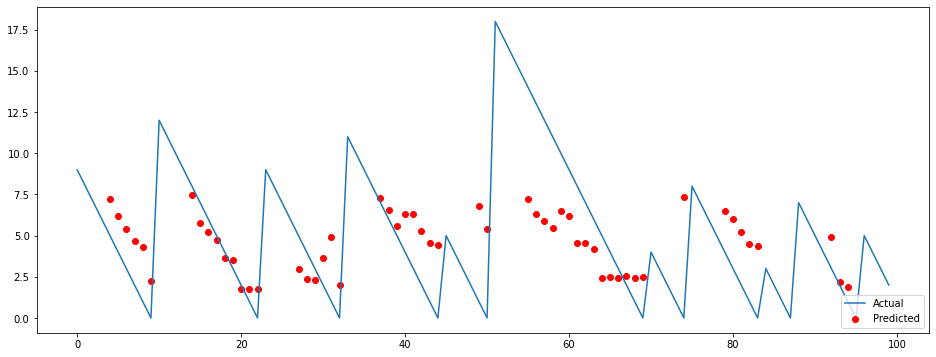

In [139]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain3[0:100])
plt.scatter(trainTime_4step_TAD[0:55], trainPredict3[0:55], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

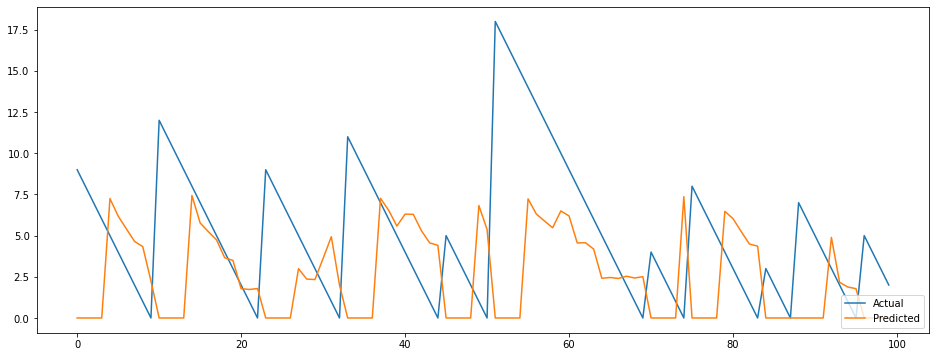

In [140]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain3[0:100])
plt.plot(trainTimeLabels[0:100], predictedTrain3[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

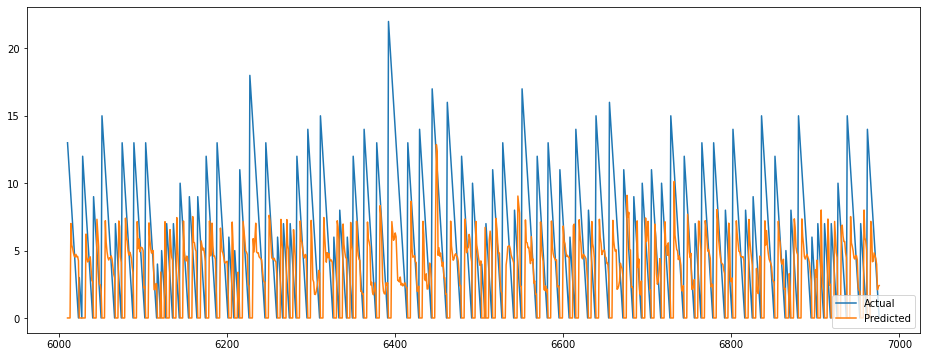

In [141]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal3)
plt.plot(valTimeLabels, predictedVal3)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

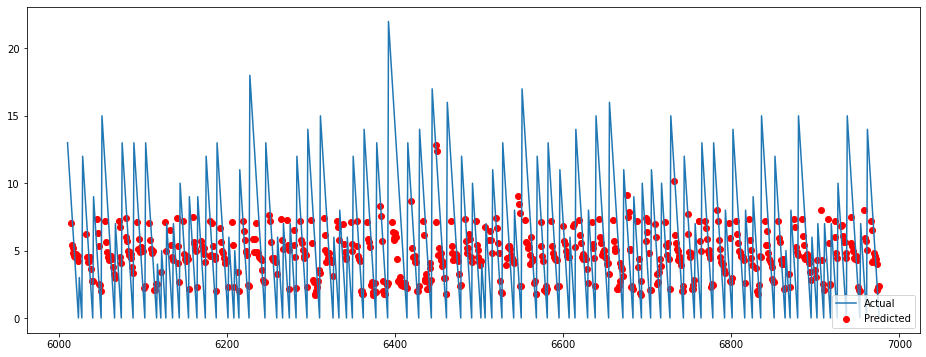

In [142]:
#validation set
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal3)
plt.scatter(valTime_4step_TAD, valPredict3, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

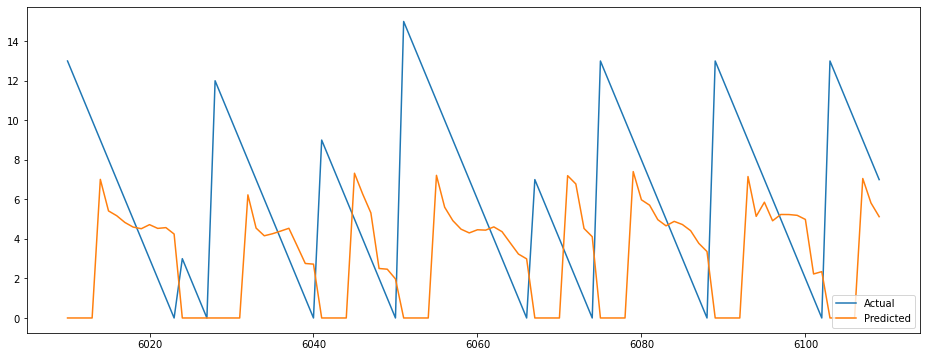

In [143]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal3[0:100])
plt.plot(valTimeLabels[0:100], predictedVal3[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

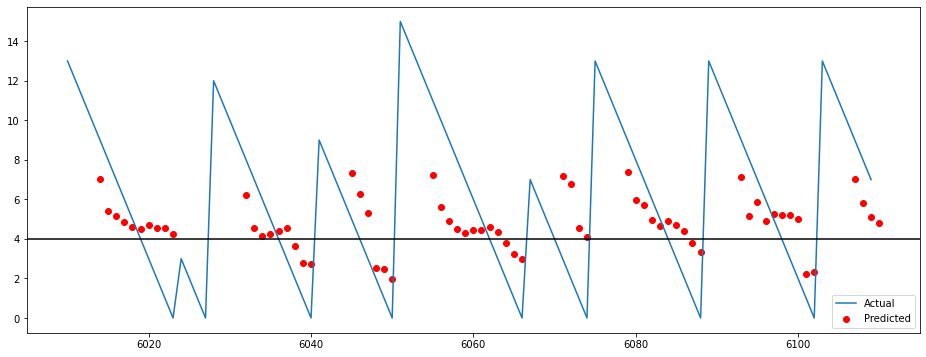

In [144]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal3[0:100])
plt.scatter(valTime_4step_TAD[0:65], valPredict3[0:65], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()

3 Dropout Layers

In [77]:
#configure architecture 
model4 = models.Sequential()
model4.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 6), padding="same"))
model4.add(layers.Dropout(0.5))
model4.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model4.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Flatten())
model4.add(layers.Dense(100, activation='relu'))
model4.add(layers.Dense(1, activation='relu'))

In [78]:
model4.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [79]:
fileName4 = "CNN_3Dropout.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName4,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [80]:
learning_model4 = model4.fit(trainX_4step_TAD_arr, trainY_4step_TAD_arr, epochs=500, batch_size=32, validation_data=(valX_4step_TAD_arr, valY_4step_TAD_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 1s 6ms/step - loss: 21.7221 - mean_squared_error: 21.7221 - val_loss: 9.9314 - val_mean_squared_error: 9.9314
Epoch 2/500
126/126 [==============================] - 1s 4ms/step - loss: 18.6533 - mean_squared_error: 18.6533 - val_loss: 10.0305 - val_mean_squared_error: 10.0305
Epoch 3/500
126/126 [==============================] - 1s 5ms/step - loss: 17.9165 - mean_squared_error: 17.9165 - val_loss: 9.9690 - val_mean_squared_error: 9.9690
Epoch 4/500
126/126 [==============================] - 1s 5ms/step - loss: 17.7664 - mean_squared_error: 17.7664 - val_loss: 10.5768 - val_mean_squared_error: 10.5768
Epoch 5/500
126/126 [==============================] - 1s 5ms/step - loss: 17.3908 - mean_squared_error: 17.3908 - val_loss: 9.6748 - val_mean_squared_error: 9.6748
Epoch 6/500
126/126 [==============================] - 1s 4ms/step - loss: 17.3638 - mean_squared_error: 17.3638 - val_loss: 9.9959 - val_mean_squared_error: 9.9959
Epoch 

126/126 [==============================] - 0s 3ms/step - loss: 16.2491 - mean_squared_error: 16.2491 - val_loss: 9.0668 - val_mean_squared_error: 9.0668
Epoch 100/500
126/126 [==============================] - 0s 4ms/step - loss: 16.3672 - mean_squared_error: 16.3672 - val_loss: 8.8810 - val_mean_squared_error: 8.8810
Epoch 101/500
126/126 [==============================] - 0s 3ms/step - loss: 16.3568 - mean_squared_error: 16.3568 - val_loss: 8.8192 - val_mean_squared_error: 8.8192
Epoch 102/500
126/126 [==============================] - 0s 4ms/step - loss: 16.3561 - mean_squared_error: 16.3561 - val_loss: 8.9431 - val_mean_squared_error: 8.9431
Epoch 103/500
126/126 [==============================] - 0s 3ms/step - loss: 16.2741 - mean_squared_error: 16.2741 - val_loss: 8.9281 - val_mean_squared_error: 8.9281
Epoch 104/500
126/126 [==============================] - 0s 4ms/step - loss: 16.2527 - mean_squared_error: 16.2527 - val_loss: 9.1277 - val_mean_squared_error: 9.1277
Epoch 105/50

126/126 [==============================] - 1s 4ms/step - loss: 16.1386 - mean_squared_error: 16.1386 - val_loss: 8.7075 - val_mean_squared_error: 8.7075
Epoch 198/500
126/126 [==============================] - 1s 4ms/step - loss: 15.9838 - mean_squared_error: 15.9838 - val_loss: 8.7604 - val_mean_squared_error: 8.7604
Epoch 199/500
126/126 [==============================] - 1s 5ms/step - loss: 15.9850 - mean_squared_error: 15.9850 - val_loss: 8.7915 - val_mean_squared_error: 8.7915
Epoch 200/500
126/126 [==============================] - 0s 4ms/step - loss: 15.9394 - mean_squared_error: 15.9394 - val_loss: 8.7883 - val_mean_squared_error: 8.7883
Epoch 201/500
126/126 [==============================] - 0s 4ms/step - loss: 15.9605 - mean_squared_error: 15.9605 - val_loss: 8.8005 - val_mean_squared_error: 8.8005
Epoch 202/500
126/126 [==============================] - 0s 3ms/step - loss: 16.0837 - mean_squared_error: 16.0837 - val_loss: 8.6692 - val_mean_squared_error: 8.6692
Epoch 203/50

126/126 [==============================] - 1s 5ms/step - loss: 15.7748 - mean_squared_error: 15.7748 - val_loss: 8.8344 - val_mean_squared_error: 8.8344
Epoch 296/500
126/126 [==============================] - 1s 4ms/step - loss: 15.8732 - mean_squared_error: 15.8732 - val_loss: 8.7144 - val_mean_squared_error: 8.7144
Epoch 297/500
126/126 [==============================] - 1s 4ms/step - loss: 15.8693 - mean_squared_error: 15.8693 - val_loss: 8.8256 - val_mean_squared_error: 8.8256
Epoch 298/500
126/126 [==============================] - 1s 4ms/step - loss: 15.8335 - mean_squared_error: 15.8335 - val_loss: 8.6488 - val_mean_squared_error: 8.6488
Epoch 299/500
126/126 [==============================] - 1s 4ms/step - loss: 15.8965 - mean_squared_error: 15.8965 - val_loss: 8.5192 - val_mean_squared_error: 8.5192
Epoch 300/500
126/126 [==============================] - 1s 5ms/step - loss: 15.7462 - mean_squared_error: 15.7462 - val_loss: 8.7483 - val_mean_squared_error: 8.7483
Epoch 301/50

126/126 [==============================] - 1s 5ms/step - loss: 15.8626 - mean_squared_error: 15.8626 - val_loss: 8.6060 - val_mean_squared_error: 8.6060
Epoch 394/500
126/126 [==============================] - 1s 5ms/step - loss: 15.8417 - mean_squared_error: 15.8417 - val_loss: 8.7652 - val_mean_squared_error: 8.7652
Epoch 395/500
126/126 [==============================] - 1s 5ms/step - loss: 15.7782 - mean_squared_error: 15.7782 - val_loss: 8.6429 - val_mean_squared_error: 8.6429
Epoch 396/500
126/126 [==============================] - 1s 5ms/step - loss: 15.7980 - mean_squared_error: 15.7980 - val_loss: 8.7438 - val_mean_squared_error: 8.7438
Epoch 397/500
126/126 [==============================] - 1s 5ms/step - loss: 15.8247 - mean_squared_error: 15.8247 - val_loss: 8.7355 - val_mean_squared_error: 8.7355
Epoch 398/500
126/126 [==============================] - 1s 5ms/step - loss: 15.6642 - mean_squared_error: 15.6642 - val_loss: 8.5030 - val_mean_squared_error: 8.5030
Epoch 399/50

126/126 [==============================] - 0s 4ms/step - loss: 15.8111 - mean_squared_error: 15.8111 - val_loss: 8.7555 - val_mean_squared_error: 8.7555
Epoch 492/500
126/126 [==============================] - 0s 4ms/step - loss: 15.6314 - mean_squared_error: 15.6314 - val_loss: 8.7233 - val_mean_squared_error: 8.7233
Epoch 493/500
126/126 [==============================] - 0s 3ms/step - loss: 15.7138 - mean_squared_error: 15.7138 - val_loss: 8.5546 - val_mean_squared_error: 8.5546
Epoch 494/500
126/126 [==============================] - 0s 4ms/step - loss: 15.7181 - mean_squared_error: 15.7181 - val_loss: 8.7797 - val_mean_squared_error: 8.7797
Epoch 495/500
126/126 [==============================] - 0s 4ms/step - loss: 15.6305 - mean_squared_error: 15.6305 - val_loss: 8.7914 - val_mean_squared_error: 8.7914
Epoch 496/500
126/126 [==============================] - 0s 4ms/step - loss: 15.7018 - mean_squared_error: 15.7018 - val_loss: 8.7077 - val_mean_squared_error: 8.7077
Epoch 497/50

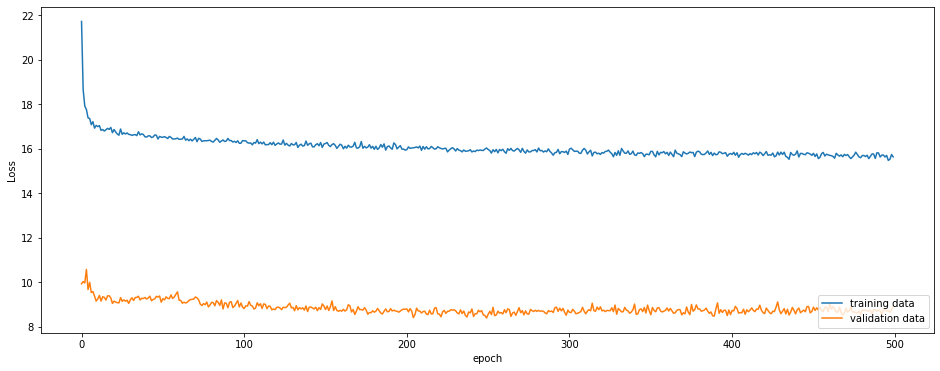

In [81]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model4.history['loss'])
plt.plot(learning_model4.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [82]:
model4 = tf.keras.models.load_model('CNN_3Dropout.h5')

In [83]:
#performance on training set
trainPredict4 = model4.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore4 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict4))
trainR2Score4 = r2_score(trainY_4step_TAD_arr, trainPredict4)
trainSscore4 = findSscore(trainY_4step_TAD_arr, trainPredict4)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore4, trainR2Score4, trainSscore4))

Train Score: 3.9418 RMSE 0.1677 R2 Score 5358.7144 S score


In [84]:
#performance on validation set
valPredict4 = model4.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore4 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict4))
valR2Score4 = r2_score(valY_4step_TAD_arr, valPredict4)
valSscore4 = findSscore(valY_4step_TAD_arr, valPredict4)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore4, valR2Score4, valSscore4))

Validation Score: 2.8973 RMSE 0.2672 R2 Score 797.3811 S score


In [85]:
(actualTrain4, predictedTrain4) = getRULValues(trainPredict4, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal4, predictedVal4) = getRULValues(valPredict4, allRUL, valTime_4step_TAD, 6010, 6976)

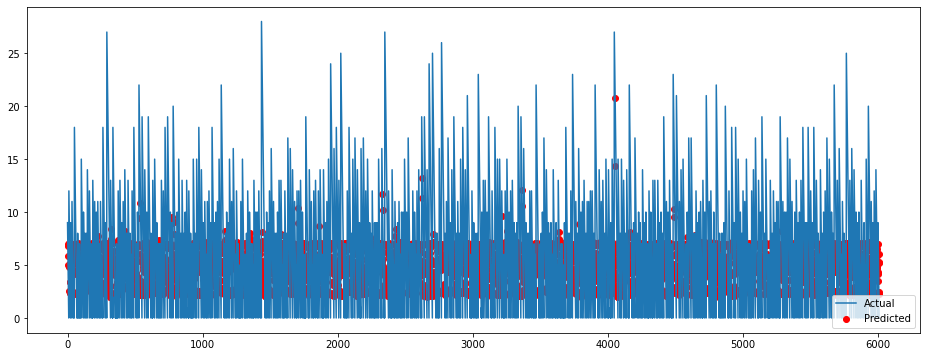

In [86]:
#training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain4)
plt.scatter(trainTime_4step_TAD, trainPredict4, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


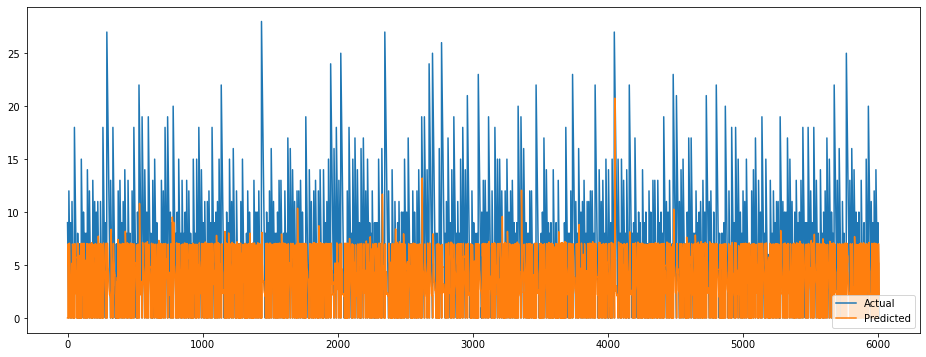

In [87]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain4)
plt.plot(trainTimeLabels, predictedTrain4)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

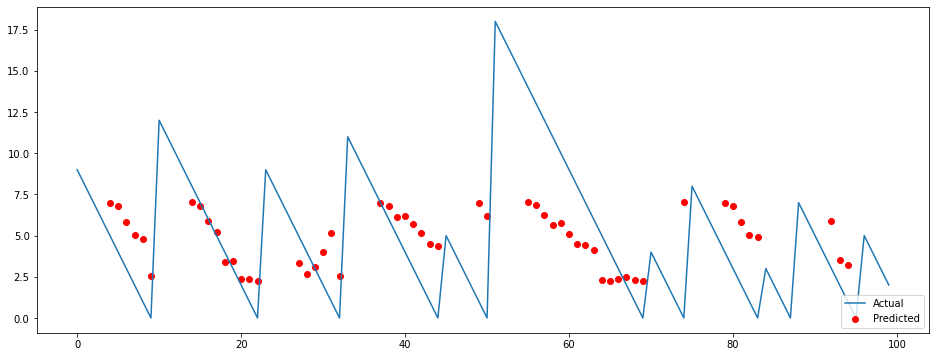

In [88]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain4[0:100])
plt.scatter(trainTime_4step_TAD[0:55], trainPredict4[0:55], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

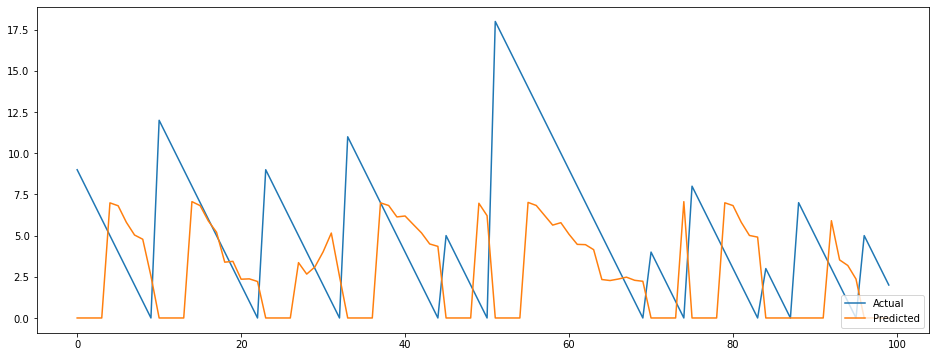

In [89]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain4[0:100])
plt.plot(trainTimeLabels[0:100], predictedTrain4[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

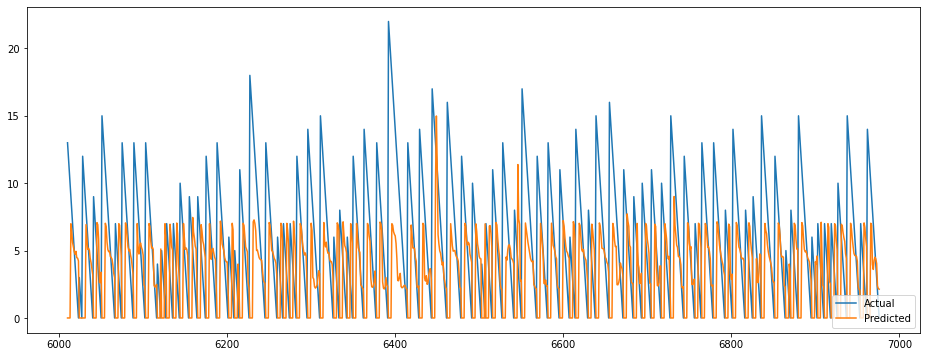

In [90]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal4)
plt.plot(valTimeLabels, predictedVal4)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

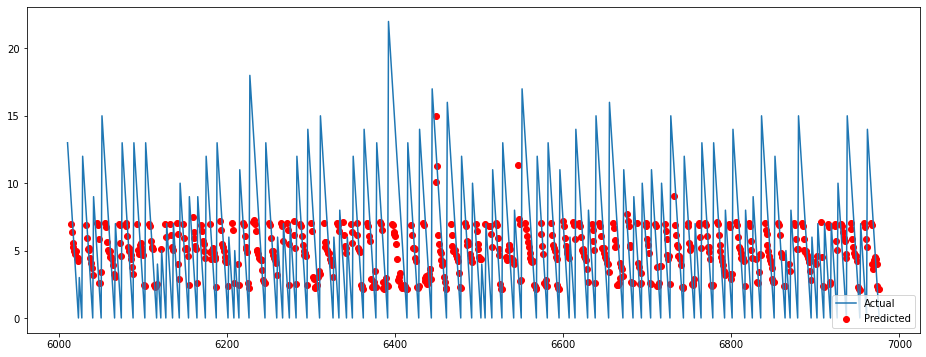

In [91]:
#validation set
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal4)
plt.scatter(valTime_4step_TAD, valPredict4, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

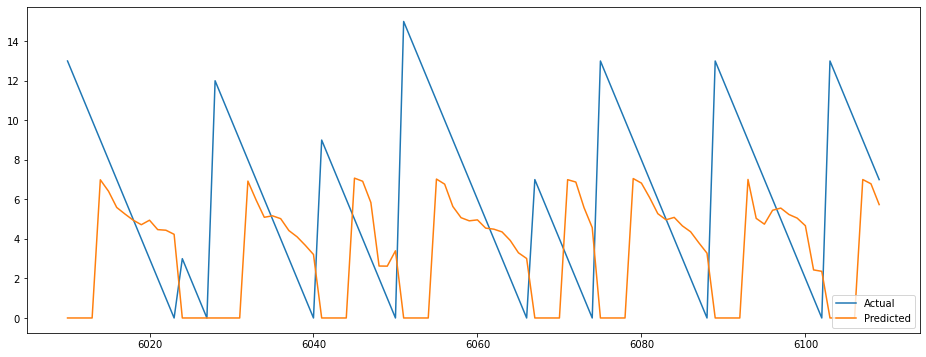

In [92]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal4[0:100])
plt.plot(valTimeLabels[0:100], predictedVal4[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

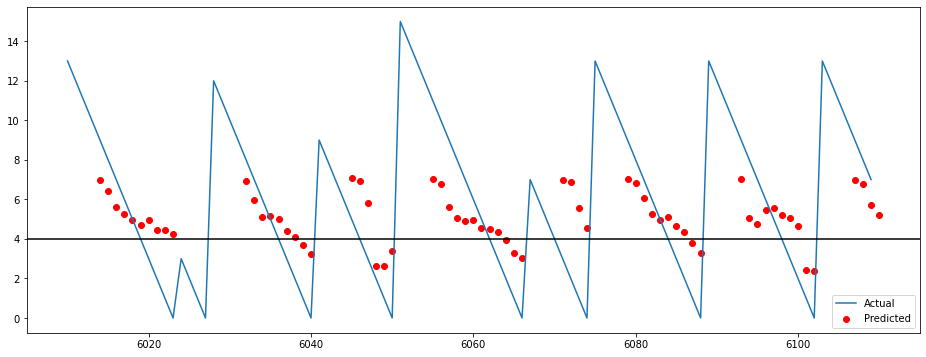

In [93]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal4[0:100])
plt.scatter(valTime_4step_TAD[0:65], valPredict4[0:65], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()

1 Dropout layer (top)

In [94]:
#configure architecture 
model5 = models.Sequential()
model5.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 6), padding="same"))
model5.add(layers.Dropout(0.5))
model5.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model5.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model5.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(100, activation='relu'))
model5.add(layers.Dense(1, activation='relu'))

In [95]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model5.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [96]:
fileName5 = "CNN_1Dropout_top.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName5,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [97]:
learning_model5 = model5.fit(trainX_4step_TAD_arr, trainY_4step_TAD_arr, epochs=500, batch_size=32, validation_data=(valX_4step_TAD_arr, valY_4step_TAD_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 1s 5ms/step - loss: 23.2385 - mean_squared_error: 23.2385 - val_loss: 9.0025 - val_mean_squared_error: 9.0025
Epoch 2/500
126/126 [==============================] - 0s 4ms/step - loss: 18.2715 - mean_squared_error: 18.2715 - val_loss: 9.0679 - val_mean_squared_error: 9.0679
Epoch 3/500
126/126 [==============================] - 0s 3ms/step - loss: 17.6776 - mean_squared_error: 17.6776 - val_loss: 8.8580 - val_mean_squared_error: 8.8580
Epoch 4/500
126/126 [==============================] - 0s 4ms/step - loss: 17.5071 - mean_squared_error: 17.5071 - val_loss: 8.8271 - val_mean_squared_error: 8.8271
Epoch 5/500
126/126 [==============================] - 0s 4ms/step - loss: 17.3718 - mean_squared_error: 17.3718 - val_loss: 8.8073 - val_mean_squared_error: 8.8073
Epoch 6/500
126/126 [==============================] - 0s 4ms/step - loss: 17.1940 - mean_squared_error: 17.1940 - val_loss: 8.8525 - val_mean_squared_error: 8.8525
Epoch 7/50

126/126 [==============================] - 1s 4ms/step - loss: 16.1292 - mean_squared_error: 16.1292 - val_loss: 8.8903 - val_mean_squared_error: 8.8903
Epoch 100/500
126/126 [==============================] - 1s 5ms/step - loss: 16.1121 - mean_squared_error: 16.1121 - val_loss: 8.8849 - val_mean_squared_error: 8.8849
Epoch 101/500
126/126 [==============================] - 1s 5ms/step - loss: 16.1665 - mean_squared_error: 16.1665 - val_loss: 8.8342 - val_mean_squared_error: 8.8342
Epoch 102/500
126/126 [==============================] - 1s 5ms/step - loss: 16.0690 - mean_squared_error: 16.0690 - val_loss: 8.8343 - val_mean_squared_error: 8.8343
Epoch 103/500
126/126 [==============================] - 1s 6ms/step - loss: 16.1431 - mean_squared_error: 16.1431 - val_loss: 8.8011 - val_mean_squared_error: 8.8011
Epoch 104/500
126/126 [==============================] - 1s 5ms/step - loss: 16.0876 - mean_squared_error: 16.0876 - val_loss: 8.9556 - val_mean_squared_error: 8.9556
Epoch 105/50

126/126 [==============================] - 1s 4ms/step - loss: 15.7778 - mean_squared_error: 15.7778 - val_loss: 8.8914 - val_mean_squared_error: 8.8914
Epoch 198/500
126/126 [==============================] - 1s 4ms/step - loss: 15.8511 - mean_squared_error: 15.8511 - val_loss: 8.8609 - val_mean_squared_error: 8.8609
Epoch 199/500
126/126 [==============================] - 1s 5ms/step - loss: 15.8344 - mean_squared_error: 15.8344 - val_loss: 8.8598 - val_mean_squared_error: 8.8598
Epoch 200/500
126/126 [==============================] - 1s 4ms/step - loss: 15.8468 - mean_squared_error: 15.8468 - val_loss: 8.8190 - val_mean_squared_error: 8.8190
Epoch 201/500
126/126 [==============================] - 0s 4ms/step - loss: 15.8066 - mean_squared_error: 15.8066 - val_loss: 8.8184 - val_mean_squared_error: 8.8184
Epoch 202/500
126/126 [==============================] - 0s 4ms/step - loss: 15.9114 - mean_squared_error: 15.9114 - val_loss: 9.0901 - val_mean_squared_error: 9.0901
Epoch 203/50

126/126 [==============================] - 1s 4ms/step - loss: 15.5769 - mean_squared_error: 15.5769 - val_loss: 8.7599 - val_mean_squared_error: 8.7599
Epoch 296/500
126/126 [==============================] - 0s 4ms/step - loss: 15.5343 - mean_squared_error: 15.5343 - val_loss: 8.6805 - val_mean_squared_error: 8.6805
Epoch 297/500
126/126 [==============================] - 1s 4ms/step - loss: 15.5656 - mean_squared_error: 15.5656 - val_loss: 8.6126 - val_mean_squared_error: 8.6126
Epoch 298/500
126/126 [==============================] - 1s 4ms/step - loss: 15.5457 - mean_squared_error: 15.5457 - val_loss: 8.8382 - val_mean_squared_error: 8.8382
Epoch 299/500
126/126 [==============================] - 1s 4ms/step - loss: 15.4958 - mean_squared_error: 15.4958 - val_loss: 8.8351 - val_mean_squared_error: 8.8351
Epoch 300/500
126/126 [==============================] - 1s 4ms/step - loss: 15.6139 - mean_squared_error: 15.6139 - val_loss: 8.5975 - val_mean_squared_error: 8.5975
Epoch 301/50

126/126 [==============================] - 1s 4ms/step - loss: 15.3892 - mean_squared_error: 15.3892 - val_loss: 8.5799 - val_mean_squared_error: 8.5799
Epoch 394/500
126/126 [==============================] - 1s 4ms/step - loss: 15.2910 - mean_squared_error: 15.2910 - val_loss: 8.7551 - val_mean_squared_error: 8.7551
Epoch 395/500
126/126 [==============================] - 1s 4ms/step - loss: 15.3793 - mean_squared_error: 15.3793 - val_loss: 8.6110 - val_mean_squared_error: 8.6110
Epoch 396/500
126/126 [==============================] - 1s 4ms/step - loss: 15.2910 - mean_squared_error: 15.2910 - val_loss: 8.6478 - val_mean_squared_error: 8.6478
Epoch 397/500
126/126 [==============================] - 1s 5ms/step - loss: 15.3721 - mean_squared_error: 15.3721 - val_loss: 8.4543 - val_mean_squared_error: 8.4543
Epoch 398/500
126/126 [==============================] - 1s 4ms/step - loss: 15.3775 - mean_squared_error: 15.3775 - val_loss: 8.6825 - val_mean_squared_error: 8.6825
Epoch 399/50

126/126 [==============================] - 0s 3ms/step - loss: 15.1875 - mean_squared_error: 15.1875 - val_loss: 8.5614 - val_mean_squared_error: 8.5614
Epoch 492/500
126/126 [==============================] - 0s 3ms/step - loss: 15.2009 - mean_squared_error: 15.2009 - val_loss: 8.6652 - val_mean_squared_error: 8.6652
Epoch 493/500
126/126 [==============================] - 0s 3ms/step - loss: 15.3395 - mean_squared_error: 15.3395 - val_loss: 8.4644 - val_mean_squared_error: 8.4644
Epoch 494/500
126/126 [==============================] - 0s 3ms/step - loss: 15.2779 - mean_squared_error: 15.2779 - val_loss: 8.6091 - val_mean_squared_error: 8.6091
Epoch 495/500
126/126 [==============================] - 0s 3ms/step - loss: 15.0737 - mean_squared_error: 15.0737 - val_loss: 8.6228 - val_mean_squared_error: 8.6228
Epoch 496/500
126/126 [==============================] - 0s 3ms/step - loss: 15.2107 - mean_squared_error: 15.2107 - val_loss: 8.5936 - val_mean_squared_error: 8.5936
Epoch 497/50

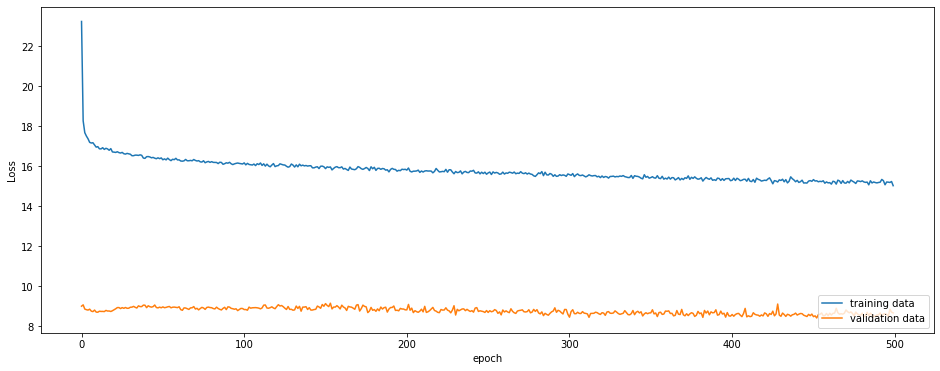

In [98]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model5.history['loss'])
plt.plot(learning_model5.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [99]:
model5 = tf.keras.models.load_model('CNN_1Dropout_top.h5')

In [100]:
#performance on training set
trainPredict5 = model5.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore5 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict5))
trainR2Score5 = r2_score(trainY_4step_TAD_arr, trainPredict5)
trainSscore5 = findSscore(trainY_4step_TAD_arr, trainPredict5)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore5, trainR2Score5, trainSscore5))

Train Score: 3.8372 RMSE 0.2113 R2 Score 5322.1237 S score


In [101]:
#performance on validation set
valPredict5 = model5.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore5 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict5))
valR2Score5 = r2_score(valY_4step_TAD_arr, valPredict5)
valSscore5 = findSscore(valY_4step_TAD_arr, valPredict5)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore5, valR2Score5, valSscore5))

Validation Score: 2.9004 RMSE 0.2656 R2 Score 797.9235 S score


In [102]:
(actualTrain5, predictedTrain5) = getRULValues(trainPredict5, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal5, predictedVal5) = getRULValues(valPredict5, allRUL, valTime_4step_TAD, 6010, 6976)

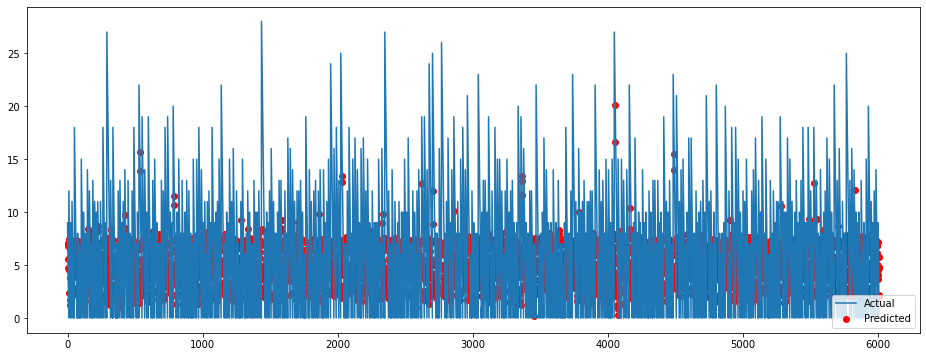

In [103]:
#training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain5)
plt.scatter(trainTime_4step_TAD, trainPredict5, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


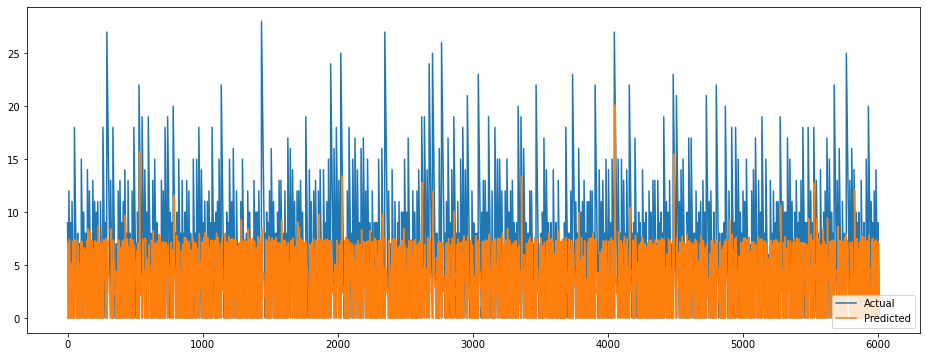

In [104]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain5)
plt.plot(trainTimeLabels, predictedTrain5)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

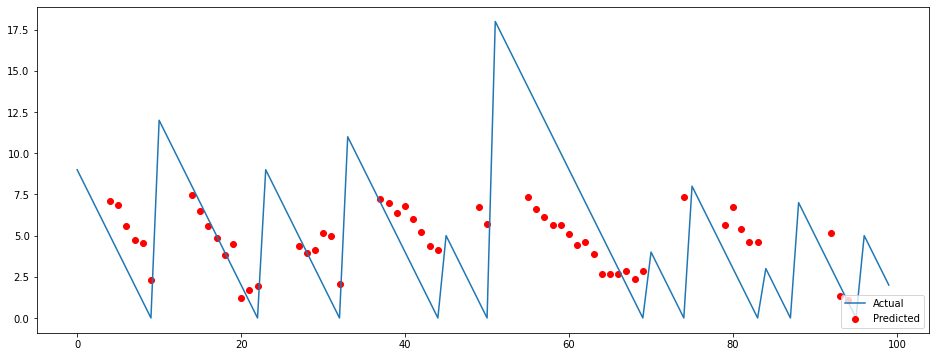

In [105]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain5[0:100])
plt.scatter(trainTime_4step_TAD[0:55], trainPredict5[0:55], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

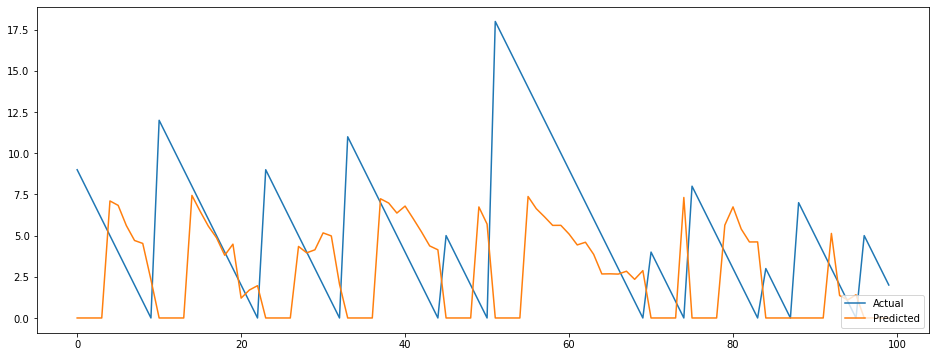

In [106]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain5[0:100])
plt.plot(trainTimeLabels[0:100], predictedTrain5[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

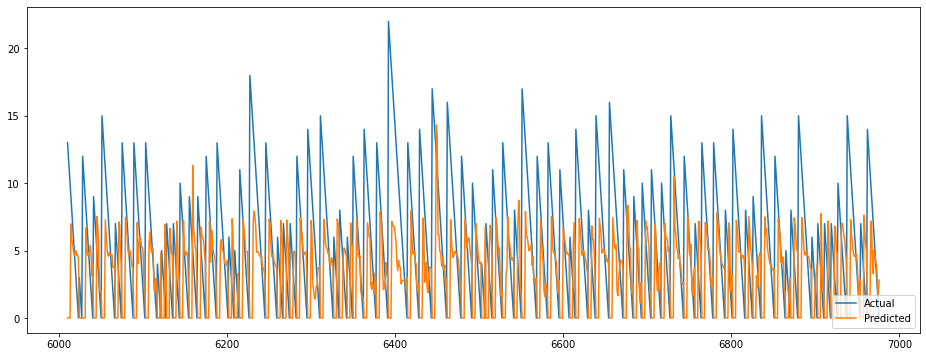

In [107]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal5)
plt.plot(valTimeLabels, predictedVal5)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

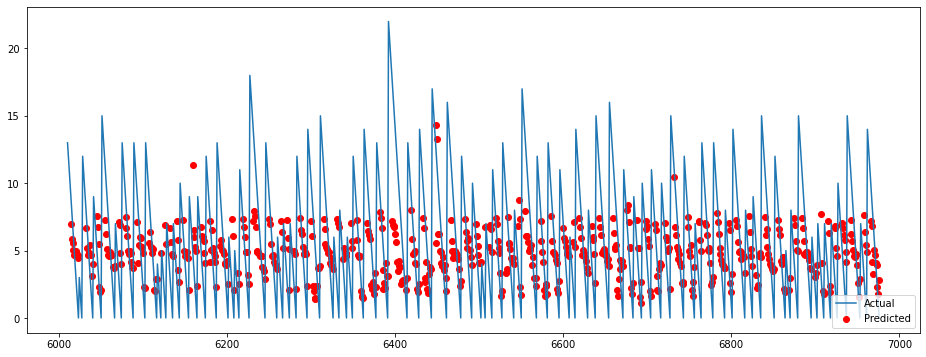

In [108]:
#validation set
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal5)
plt.scatter(valTime_4step_TAD, valPredict5, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

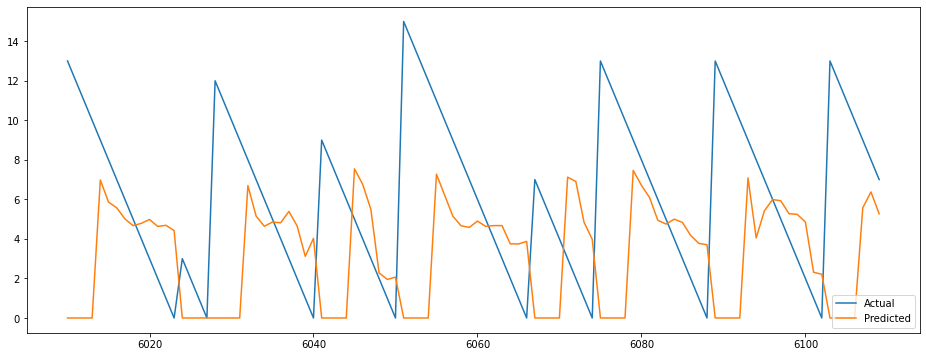

In [109]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal5[0:100])
plt.plot(valTimeLabels[0:100], predictedVal5[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

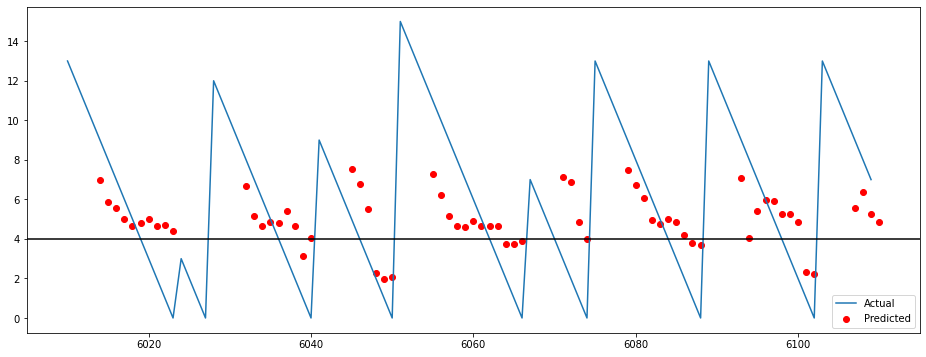

In [110]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal5[0:100])
plt.scatter(valTime_4step_TAD[0:65], valPredict5[0:65], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()

1 Dropout layer (middle)

In [111]:
#configure architecture 
model6 = models.Sequential()
model6.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 6), padding="same"))
model6.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model6.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model6.add(layers.Dropout(0.5))
model6.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model6.add(layers.Flatten())
model6.add(layers.Dense(100, activation='relu'))
model6.add(layers.Dense(1, activation='relu'))

In [112]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model6.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [113]:
fileName6 = "CNN_1Dropout_middle.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName6,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [114]:
learning_model6 = model6.fit(trainX_4step_TAD_arr, trainY_4step_TAD_arr, epochs=500, batch_size=32, validation_data=(valX_4step_TAD_arr, valY_4step_TAD_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 1s 5ms/step - loss: 21.1251 - mean_squared_error: 21.1251 - val_loss: 9.0905 - val_mean_squared_error: 9.0905
Epoch 2/500
126/126 [==============================] - 0s 4ms/step - loss: 18.0782 - mean_squared_error: 18.0782 - val_loss: 9.3795 - val_mean_squared_error: 9.3795
Epoch 3/500
126/126 [==============================] - 1s 6ms/step - loss: 17.7118 - mean_squared_error: 17.7118 - val_loss: 8.9593 - val_mean_squared_error: 8.9593
Epoch 4/500
126/126 [==============================] - 1s 5ms/step - loss: 17.6119 - mean_squared_error: 17.6119 - val_loss: 8.6801 - val_mean_squared_error: 8.6801
Epoch 5/500
126/126 [==============================] - 1s 5ms/step - loss: 17.3848 - mean_squared_error: 17.3848 - val_loss: 8.6509 - val_mean_squared_error: 8.6509
Epoch 6/500
126/126 [==============================] - 1s 5ms/step - loss: 17.4262 - mean_squared_error: 17.4262 - val_loss: 8.5538 - val_mean_squared_error: 8.5538
Epoch 7/50

126/126 [==============================] - 0s 4ms/step - loss: 15.8585 - mean_squared_error: 15.8585 - val_loss: 8.8206 - val_mean_squared_error: 8.8206
Epoch 100/500
126/126 [==============================] - 1s 4ms/step - loss: 15.9682 - mean_squared_error: 15.9682 - val_loss: 8.7083 - val_mean_squared_error: 8.7083
Epoch 101/500
126/126 [==============================] - 0s 4ms/step - loss: 15.8786 - mean_squared_error: 15.8786 - val_loss: 8.7407 - val_mean_squared_error: 8.7407
Epoch 102/500
126/126 [==============================] - 0s 4ms/step - loss: 15.9511 - mean_squared_error: 15.9511 - val_loss: 8.7742 - val_mean_squared_error: 8.7742
Epoch 103/500
126/126 [==============================] - 1s 4ms/step - loss: 15.9250 - mean_squared_error: 15.9250 - val_loss: 8.6812 - val_mean_squared_error: 8.6812
Epoch 104/500
126/126 [==============================] - 1s 5ms/step - loss: 15.8681 - mean_squared_error: 15.8681 - val_loss: 8.8615 - val_mean_squared_error: 8.8615
Epoch 105/50

126/126 [==============================] - 0s 3ms/step - loss: 15.2493 - mean_squared_error: 15.2493 - val_loss: 8.6471 - val_mean_squared_error: 8.6471
Epoch 198/500
126/126 [==============================] - 0s 3ms/step - loss: 15.2304 - mean_squared_error: 15.2304 - val_loss: 8.6474 - val_mean_squared_error: 8.6474
Epoch 199/500
126/126 [==============================] - 0s 3ms/step - loss: 15.3242 - mean_squared_error: 15.3242 - val_loss: 8.6603 - val_mean_squared_error: 8.6603
Epoch 200/500
126/126 [==============================] - 0s 3ms/step - loss: 15.2629 - mean_squared_error: 15.2629 - val_loss: 8.8378 - val_mean_squared_error: 8.8378
Epoch 201/500
126/126 [==============================] - 0s 3ms/step - loss: 15.1694 - mean_squared_error: 15.1694 - val_loss: 8.6123 - val_mean_squared_error: 8.6123
Epoch 202/500
126/126 [==============================] - 0s 3ms/step - loss: 15.2247 - mean_squared_error: 15.2247 - val_loss: 8.8301 - val_mean_squared_error: 8.8301
Epoch 203/50

126/126 [==============================] - 1s 7ms/step - loss: 14.8303 - mean_squared_error: 14.8303 - val_loss: 8.8790 - val_mean_squared_error: 8.8790
Epoch 296/500
126/126 [==============================] - 1s 6ms/step - loss: 14.6584 - mean_squared_error: 14.6584 - val_loss: 8.9431 - val_mean_squared_error: 8.9431
Epoch 297/500
126/126 [==============================] - 1s 6ms/step - loss: 14.6969 - mean_squared_error: 14.6969 - val_loss: 9.0422 - val_mean_squared_error: 9.0422
Epoch 298/500
126/126 [==============================] - 1s 6ms/step - loss: 14.7845 - mean_squared_error: 14.7845 - val_loss: 8.9010 - val_mean_squared_error: 8.9010
Epoch 299/500
126/126 [==============================] - 1s 7ms/step - loss: 14.6928 - mean_squared_error: 14.6928 - val_loss: 9.1040 - val_mean_squared_error: 9.1040
Epoch 300/500
126/126 [==============================] - 1s 7ms/step - loss: 14.5483 - mean_squared_error: 14.5483 - val_loss: 8.9793 - val_mean_squared_error: 8.9793
Epoch 301/50

126/126 [==============================] - 1s 4ms/step - loss: 14.3615 - mean_squared_error: 14.3615 - val_loss: 8.8542 - val_mean_squared_error: 8.8542
Epoch 394/500
126/126 [==============================] - 0s 3ms/step - loss: 14.0484 - mean_squared_error: 14.0484 - val_loss: 8.8910 - val_mean_squared_error: 8.8910
Epoch 395/500
126/126 [==============================] - 0s 3ms/step - loss: 14.1674 - mean_squared_error: 14.1674 - val_loss: 9.3142 - val_mean_squared_error: 9.3142
Epoch 396/500
126/126 [==============================] - 0s 4ms/step - loss: 14.1697 - mean_squared_error: 14.1697 - val_loss: 8.9143 - val_mean_squared_error: 8.9143
Epoch 397/500
126/126 [==============================] - 0s 4ms/step - loss: 14.0506 - mean_squared_error: 14.0506 - val_loss: 9.0504 - val_mean_squared_error: 9.0504
Epoch 398/500
126/126 [==============================] - 0s 3ms/step - loss: 14.0176 - mean_squared_error: 14.0176 - val_loss: 9.0604 - val_mean_squared_error: 9.0604
Epoch 399/50

126/126 [==============================] - 0s 4ms/step - loss: 13.7624 - mean_squared_error: 13.7624 - val_loss: 9.1605 - val_mean_squared_error: 9.1605
Epoch 492/500
126/126 [==============================] - 0s 4ms/step - loss: 13.8474 - mean_squared_error: 13.8474 - val_loss: 9.1157 - val_mean_squared_error: 9.1157
Epoch 493/500
126/126 [==============================] - 1s 4ms/step - loss: 13.7234 - mean_squared_error: 13.7234 - val_loss: 9.4183 - val_mean_squared_error: 9.4183
Epoch 494/500
126/126 [==============================] - 1s 5ms/step - loss: 13.4783 - mean_squared_error: 13.4783 - val_loss: 9.2955 - val_mean_squared_error: 9.2955
Epoch 495/500
126/126 [==============================] - 1s 4ms/step - loss: 13.8579 - mean_squared_error: 13.8579 - val_loss: 9.0041 - val_mean_squared_error: 9.0041
Epoch 496/500
126/126 [==============================] - 1s 5ms/step - loss: 13.5872 - mean_squared_error: 13.5872 - val_loss: 9.2972 - val_mean_squared_error: 9.2972
Epoch 497/50

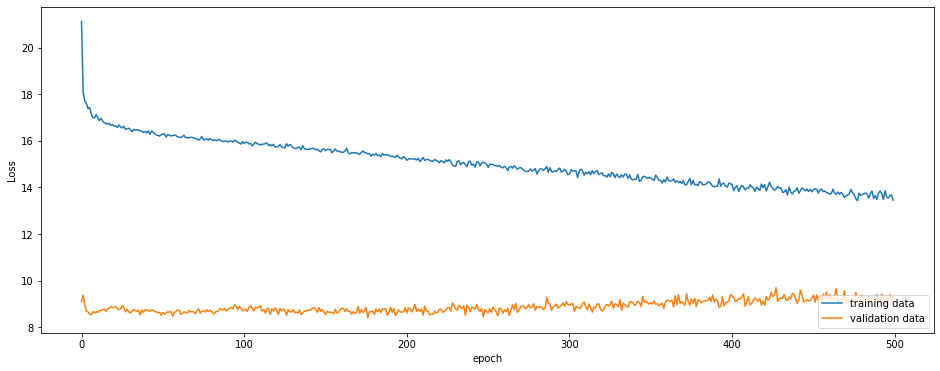

In [115]:
plt.figure(figsize=(16, 6))
plt.plot(learning_model6.history['loss'])
plt.plot(learning_model6.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [116]:
model6 = tf.keras.models.load_model('CNN_1Dropout_middle.h5')

In [117]:
#performance on training set
trainPredict6 = model6.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore6 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict6))
trainR2Score6 = r2_score(trainY_4step_TAD_arr, trainPredict6)
trainSscore6 = findSscore(trainY_4step_TAD_arr, trainPredict6)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore6, trainR2Score6, trainSscore6))

Train Score: 3.9051 RMSE 0.1832 R2 Score 5337.5436 S score


In [118]:
#performance on validation set
valPredict6 = model6.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore6 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict6))
valR2Score6 = r2_score(valY_4step_TAD_arr, valPredict6)
valSscore6 = findSscore(valY_4step_TAD_arr, valPredict6)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore6, valR2Score6, valSscore6))

Validation Score: 2.8974 RMSE 0.2671 R2 Score 795.8089 S score


In [119]:
(actualTrain6, predictedTrain6) = getRULValues(trainPredict6, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal6, predictedVal6) = getRULValues(valPredict6, allRUL, valTime_4step_TAD, 6010, 6976)

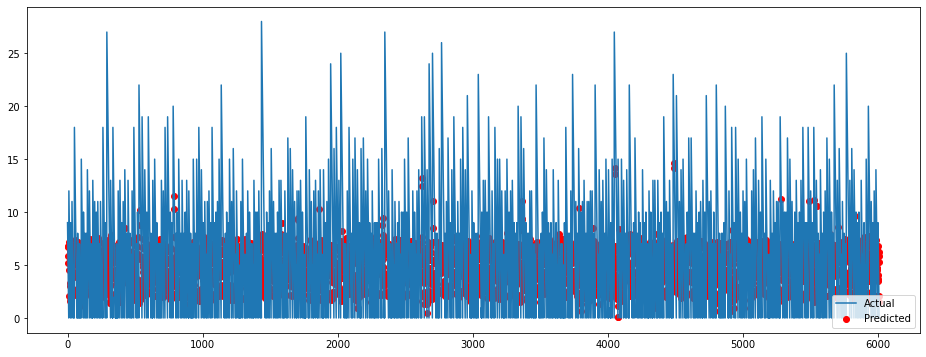

In [120]:
#training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain6)
plt.scatter(trainTime_4step_TAD, trainPredict6, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


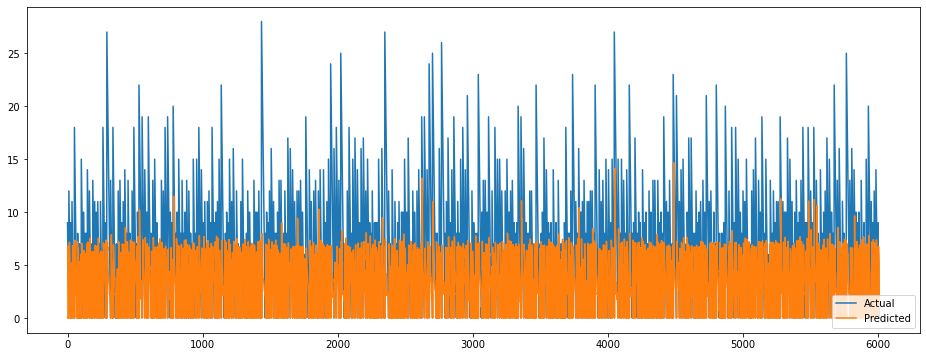

In [121]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain6)
plt.plot(trainTimeLabels, predictedTrain6)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

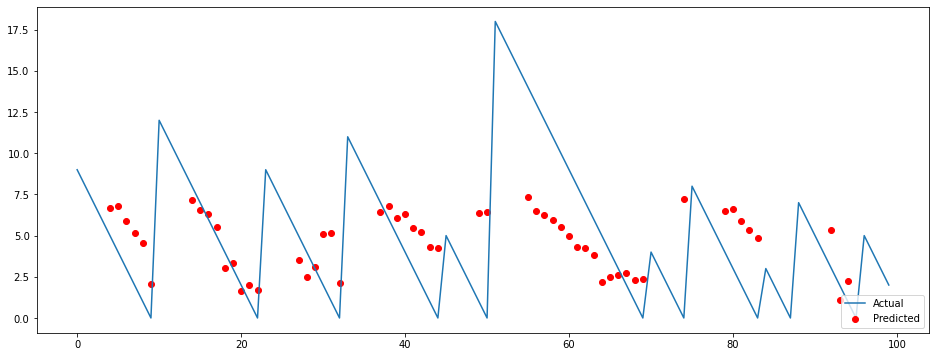

In [122]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain6[0:100])
plt.scatter(trainTime_4step_TAD[0:55], trainPredict6[0:55], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

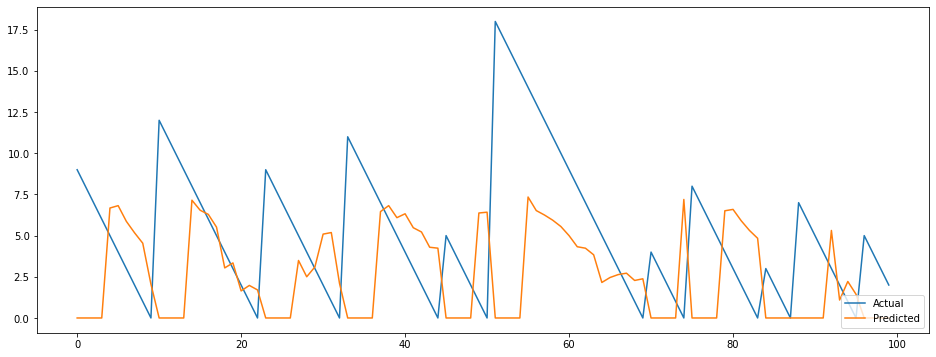

In [123]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain6[0:100])
plt.plot(trainTimeLabels[0:100], predictedTrain6[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

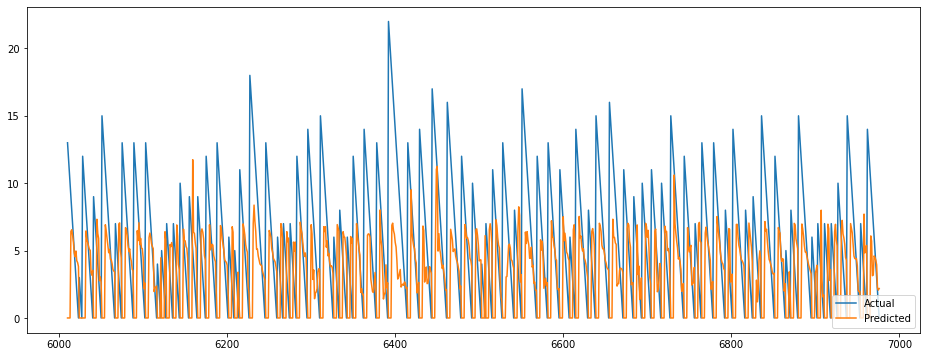

In [124]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal6)
plt.plot(valTimeLabels, predictedVal6)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

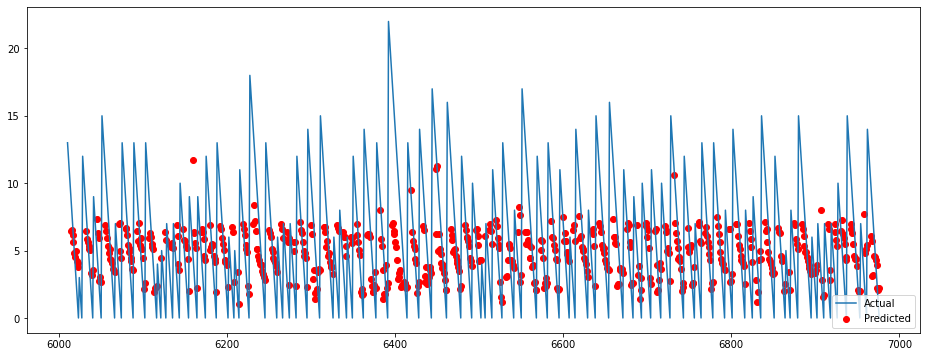

In [125]:
#validation set
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal6)
plt.scatter(valTime_4step_TAD, valPredict6, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

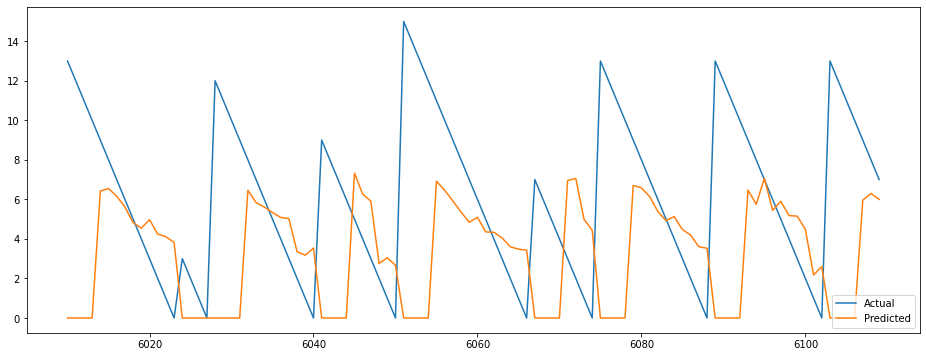

In [126]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal6[0:100])
plt.plot(valTimeLabels[0:100], predictedVal6[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

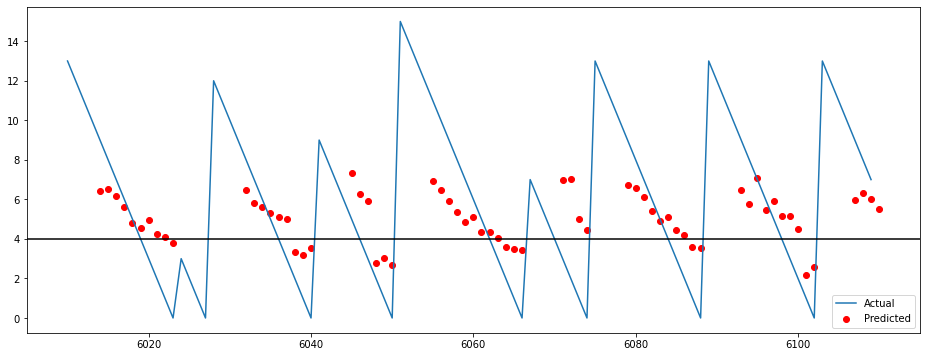

In [127]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal6[0:100])
plt.scatter(valTime_4step_TAD[0:65], valPredict6[0:65], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.axhline(y=4, color='k', linestyle='-')
plt.show()

2 Dropout layers in the middle gave the best result. 